In [1]:
%%time
! pip install anndata scanpy umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 77.1 ms, sys: 16.3 ms, total: 93.4 ms
Wall time: 7.99 s


In [2]:
import os
import csv
import time
import concurrent.futures
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import scipy.io
import scipy.sparse
import matplotlib as mpl
import math
import tensorflow as tf
import pkg_resources

# Need to install via pip
import anndata
import scanpy as sc

In [3]:
PLOT_UMAPS = False

# Create scores df

In [4]:
ORDER = [
        'raw',
        #'filtered_top_1000',
        'filtered_q_75',
        'filtered_q_50',
        'filtered_q_20',
        'filtered_q_10',
        'filtered_q_5',
        'filtered_q_1',
        'filtered_hvg_75',
        'filtered_hvg_50',
        'filtered_hvg_20',
        'filtered_hvg_10',
        'filtered_hvg_5',
        'filtered_hvg_1',
        'filtered_cell_baseline',
        'filtered_cell_q_0_50',
        'filtered_cell_q_10_60',
        'filtered_cell_q_20_70',
        'filtered_cell_q_30_80',
        'filtered_cell_q_40_90',
        'filtered_cell_q_50_100',
        'sampled_cell_p_80',
        'sampled_cell_p_60',
        'sampled_cell_p_40',
        'sampled_cell_p_20',
        'filtered_cell_q_10_100',
        'filtered_cell_q_20_100',
        'filtered_cell_q_30_100',
        'filtered_cell_q_40_100',
        'filtered_cell_q_50_100',
        'filtered_cell_q_60_100',
]


ORDERS = {
    'top features': [
        'raw',
        'filtered_q_75',
        'filtered_q_50',
        'filtered_q_20',
        'filtered_q_10',
        'filtered_q_5',
        'filtered_q_1',
    ],
    'highly variable features': [
        'raw',
        'filtered_hvg_75',
        'filtered_hvg_50',
        'filtered_hvg_20',
        'filtered_hvg_10',
        'filtered_hvg_5',
        'filtered_hvg_1',                       
    ],
    'percentage of cells': [
        'raw',
        'sampled_cell_p_80',
        'sampled_cell_p_60',
        'sampled_cell_p_40',
        'sampled_cell_p_20',
    ],
    'coverage percentiles': [
        'raw',
        'filtered_cell_baseline',
        'filtered_cell_q_0_50',
        'filtered_cell_q_10_60',
        'filtered_cell_q_20_70',
        'filtered_cell_q_30_80',
        'filtered_cell_q_40_90',
        'filtered_cell_q_50_100',
    ],
    'coverage filtering': [
        'filtered_cell_q_0_100',
        'filtered_cell_q_10_100',
        'filtered_cell_q_20_100',
        'filtered_cell_q_30_100',
        'filtered_cell_q_40_100',
        'filtered_cell_q_50_100',
        'filtered_cell_q_60_100',
    ]
}

METHODS_ORDER = [
        'Signac',
        'ChromSCape_LSI',
 #       'ChromSCape_white_LSI',
 #       'ChromSCape_LSI_50',
 #       'Signac_10',
        'PeakVI',
        'SnapATAC',
        'cisTopic',
        'SCALE',  
        'ChromSCape_PCA',
        'NMF',
        'TFIDF-NMF'       
]

FULL_METHODS_ORDER = [
        'Signac',
        'ChromSCape_LSI',
        'ChromSCape_white_LSI',
        'ChromSCape_LSI_50',
        'Signac_10',
        'PeakVI',
        'SnapATAC',
        'cisTopic',
        'SCALE',  
        'ChromSCape_PCA',
        'NMF',
        'TFIDF-NMF'         
]

MARKS_ORDER = [
        'H3K27me3',
        'H3K9me3',
        'H3K27ac',
        'H3K4me1',
        'H3K4me3',
]

BINSIZES = [f'SicerPseudoBulk{w}' for w in [200, 500, 2000, 5000, 20000]]
BINSIZES += ['MACS2PseudBulk', 'GeneTSS', '5kbp', '10kbp', '20kbp', '30kbp', '50kbp', '100kbp', '200kbp', '300kbp', '500kbp', '1000kbp']

_SICERS = [f'SicerPseudoBulk{w}' for w in [200, 500, 2000, 5000, 20000]]

In [61]:
! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/raw_scores.csv raw_scores.csv
! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/nmf.csv nmf.csv
! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/zhang_neighbor.csv zhang_neighbor.csv
! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/sizes_scores.csv sizes_scores.csv 

! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/zhu_supervised.csv zhu_supervised.csv
! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/zhang_supervised.csv zhang_supervised.csv
! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/grosselin_supervised.csv grosselin_supervised.csv


! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/logs/time_features.txt time_features.txt
! wget https://github.com/vallotlab/benchmark_scepigenomics/raw/main/logs/time_correct.txt time_correct.txt



! mkdir -p figures

--2023-02-10 13:34:03--  https://github.com/vallotlab/benchmark_scepigenomics/raw/main/data/scores/raw_scores.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vallotlab/benchmark_scepigenomics/main/data/scores/raw_scores.csv [following]
--2023-02-10 13:34:03--  https://raw.githubusercontent.com/vallotlab/benchmark_scepigenomics/main/data/scores/raw_scores.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13903760 (13M) [text/plain]
Saving to: ‘raw_scores.csv.2’

raw_scores.csv.2    100%[===================>]  13.26M  --.-KB/s    in 0.1s    

2023-02-10 13:34:03 (120 MB/s) - ‘raw_scores.csv.


Read raw scores

In [6]:
def save_figure(fname, lgd, base_path='figures/'):
  """
  Uses side effects to save a figures on drive.
  fname: name of the figure.
  base_path: path on drive to store the figure.
  """
  with tf.io.gfile.GFile(os.path.join(base_path, fname), mode='w') as f:
    plt.savefig(f, format='pdf', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [7]:
def compute_auc(scores):
  scores = sorted(scores, key=lambda x: x[0])
  frac, score = scores[0]
  total_auc = 0
  total_aulc = 0
  avg = scores[0][1]
  for f, s in scores[1:]:
    total_auc += (f - frac) * (score + s) / 2
    total_aulc += (np.log10(f) - np.log10(frac)) * (score + s) / 2
    avg += s
    frac, score = f, s
  avg /= len(scores)
  return (total_auc / frac), (total_aulc / (np.log10(frac) - np.log10(scores[0][0]))), avg


def extract_curves(df, mark, method, feature_selection, source):
  res = list()
  local = df[(df['Mark'] == mark) &
             (df['Method'] == method) &
             (df['feature_selection'] == feature_selection) &
             (df['Dataset'] == source)]
  for bs in local['binsize'].unique():
    scores = local[local['binsize'] == bs]
    scores = list(scores[['fraction', 'frac. shared neighbors']].to_records(index=False))
    auc, aulc, avg = compute_auc(scores)
    res.append({
        'neighbor score': auc,
        'AULC': aulc,
        'Avg': avg,
        'source': source,
        'Mark': mark,
        'Method': method,
        'feature_selection': feature_selection,
        'binsize': int(bs) if ((bs != 'GeneTSS') and (bs != 'PseudoBulk') and (bs not in _SICERS)) else bs
    })
  return res

def compute_scores(df):
  res = []
  for source in df['Dataset'].unique():
    for mark in df['Mark'].unique():
      for method in df['Method'].unique():
        for fs in df['feature_selection'].unique():
          res.append(pd.DataFrame.from_records(extract_curves(df, mark, method, fs, source)))
  return pd.concat(res, ignore_index=True)

In [8]:
%%time

with tf.io.gfile.GFile('raw_scores.csv', mode='r') as f:
  df = pd.read_csv(f, index_col=0)


def filtering(row):
  if row['Dataset'] == 'PairedTag_Zhu_2021':
    return True
  else:
    if row['feature_selection'] == 'raw':
      if (row['Method'] == 'PeakVI') or (row['Method'] == 'SCALE'):
        return True
  return False

df= df[df.apply(filtering, axis=1)]


with tf.io.gfile.GFile('zhang_neighbor.csv', mode='r') as f:
  zhang = pd.read_csv(f, index_col=0)


with tf.io.gfile.GFile('sizes_scores.csv', mode='r') as f:
  sizes = pd.read_csv(f, index_col=0)

with tf.io.gfile.GFile('nmf.csv', mode='r') as f:
  nmf = pd.read_csv(f, index_col=0)


df = pd.concat([df, zhang, sizes, nmf], ignore_index=True)

def rename_bs(bs):
  if (bs == 'GeneTSS') or (bs in _SICERS):
    return bs
  if bs == 'PseudoBulk':
    return 'MACS2PseudBulk'
  else:
    return f'{bs}kbp'

def rename_bs_log(bs):
  if bs == 'GeneTSS':
    return 3000
  elif bs == 'PseudoBulk':
    return 1000
  elif bs in _SICERS:
    return int(bs[len('SicerPseudoBulk'):]) / 100
  else:
    return int(bs) * 1000

def rename_method(m):
  prefix = 'Chromscape'
  if m[:len(prefix)] == prefix:
    return 'ChromSCape' + m[len(prefix):]
  else:
    return m

scores = compute_scores(df)

scores['binsize_raw'] = scores['binsize']
scores['binsize_log'] = scores['binsize'].map(rename_bs_log)
scores['binsize'] = scores['binsize'].map(rename_bs)
scores['binsize'] = pd.Categorical(scores['binsize'],
                                   categories=BINSIZES,
                                   ordered=True)
scores['Mark'] = pd.Categorical(scores['Mark'],
                                categories=MARKS_ORDER,
                                ordered=True)
scores['Method'] = scores['Method'].map(rename_method)
scores['Method'] = pd.Categorical(scores['Method'],
                                  categories=FULL_METHODS_ORDER,
                                  ordered=True)

scores.to_csv('processed_neighbor_score.csv')

CPU times: user 6min 42s, sys: 1.61 s, total: 6min 44s
Wall time: 6min 56s


In [9]:
with tf.io.gfile.GFile('grosselin_supervised.csv', mode='r') as f:
  grosselin = pd.read_csv(f, index_col=0)

with tf.io.gfile.GFile('zhu_supervised.csv', mode='r') as f:
  zhu = pd.read_csv(f, index_col=0)

with tf.io.gfile.GFile('zhang_supervised.csv', mode='r') as f:
  zhang = pd.read_csv(f, index_col=0)

supervised = pd.concat([grosselin, zhang, zhu], ignore_index=True)


supervised['binsize_raw'] = supervised['binsize']

supervised['binsize_log'] = supervised['binsize'].map(rename_bs_log)
supervised['binsize'] = supervised['binsize'].map(rename_bs)
supervised['binsize'] = pd.Categorical(supervised['binsize'],
                                       categories=BINSIZES,
                                       ordered=True)
supervised['Mark'] = pd.Categorical(supervised['Mark'],
                                    categories=MARKS_ORDER,
                                    ordered=True)
supervised['Method'] = supervised['Method'].map(rename_method)
supervised['Method'] = pd.Categorical(supervised['Method'],
                                      categories=METHODS_ORDER,
                                      ordered=True)
supervised['source'] = supervised['Dataset']

supervised.to_csv('processed_supervised_score.csv')

# Create CMAP

In [10]:
# Taken from https://github.com/BlakeRMills/MetBrewer

from matplotlib.colors import LinearSegmentedColormap, to_hex

MET_PALETTES = dict(
    Austria=dict(colors=("#a40000", "#16317d", "#007e2f", "#ffcd12", "#b86092", "#721b3e", "#00b7a7"), order=(1, 2, 3, 4, 6, 5, 7), colorblind=False),
    Cassatt1=dict(colors=("#b1615c", "#d88782", "#e3aba7", "#edd7d9", "#c9c9dd", "#9d9dc7", "#8282aa", "#5a5a83"), order=(3, 6, 1, 8, 4, 5, 2, 7), colorblind=True),
    Cassatt2=dict(colors=("#2d223c", "#574571", "#90719f", "#b695bc", "#dec5da", "#c1d1aa", "#7fa074", "#466c4b", "#2c4b27", "#0e2810"), order=(7, 3, 9, 1, 5, 6, 2, 10, 4, 8), colorblind=True),
    Cross=dict(colors=("#c969a1", "#ce4441", "#ee8577", "#eb7926", "#ffbb44", "#859b6c", "#62929a", "#004f63", "#122451"), order=(4, 7, 1, 8, 2, 6, 3, 5, 9), colorblind=False),
    Degas=dict(colors=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29"), order=(5, 2, 1, 3, 4, 7, 6), colorblind=False),
    Derain=dict(colors=("#efc86e", "#97c684", "#6f9969", "#aab5d5", "#808fe1", "#5c66a8", "#454a74"), order=(4, 2, 5, 7, 1, 3, 6), colorblind=True),
    Egypt=dict(colors=("#dd5129", "#0f7ba2", "#43b284", "#fab255"), order=(1, 2, 3, 4), colorblind=True),
    Gauguin=dict(colors=("#b04948", "#811e18", "#9e4013", "#c88a2c", "#4c6216", "#1a472a"), order=(2, 5, 4, 3, 1, 6), colorblind=False),
    Greek=dict(colors=("#3c0d03", "#8d1c06", "#e67424", "#ed9b49", "#f5c34d"), order=(2, 3, 5, 1, 4), colorblind=True),
    Hiroshige=dict(colors=("#e76254", "#ef8a47", "#f7aa58", "#ffd06f", "#ffe6b7", "#aadce0", "#72bcd5", "#528fad", "#376795", "#1e466e"), order=(6, 2, 9, 3, 7, 5, 1, 10, 4, 8), colorblind=True),
    Hokusai1=dict(colors=("#6d2f20", "#b75347", "#df7e66", "#e09351", "#edc775", "#94b594", "#224b5e"), order=(2, 7, 4, 6, 5, 1, 3), colorblind=False),
    Hokusai2=dict(colors=("#abc9c8", "#72aeb6", "#4692b0", "#2f70a1", "#134b73", "#0a3351"), order=(5, 2, 4, 1, 6, 3), colorblind=True),
    Hokusai3=dict(colors=("#d8d97a", "#95c36e", "#74c8c3", "#5a97c1", "#295384", "#0a2e57"), order=(4, 2, 5, 3, 1, 6), colorblind=True),
    Homer1=dict(colors=("#551f00", "#a62f00", "#df7700", "#f5b642", "#fff179", "#c3f4f6", "#6ad5e8", "#32b2da"), order=(6, 3, 2, 7, 4, 8, 5, 1), colorblind=False),
    Homer2=dict(colors=("#bf3626", "#e9724c", "#e9851d", "#f9c53b", "#aeac4c", "#788f33", "#165d43"), order=(3, 7, 1, 4, 6, 2, 5), colorblind=False),
    Ingres=dict(colors=("#041d2c", "#06314e", "#18527e", "#2e77ab", "#d1b252", "#a97f2f", "#7e5522", "#472c0b"), order=(4, 5, 3, 6, 2, 7, 1, 8), colorblind=True),
    Isfahan1=dict(colors=("#4e3910", "#845d29", "#d8c29d", "#4fb6ca", "#178f92", "#175f5d", "#1d1f54"), order=(5, 2, 4, 6, 1, 7, 3), colorblind=True),
    Isfahan2=dict(colors=("#d7aca1", "#ddc000", "#79ad41", "#34b6c6", "#4063a3"), order=(4, 2, 3, 5, 1), colorblind=True),
    Juarez=dict(colors=("#a82203", "#208cc0", "#f1af3a", "#cf5e4e", "#637b31", "#003967"), order=(1, 2, 3, 4, 5, 6), colorblind=False),
    Klimt=dict(colors=("#df9ed4", "#c93f55", "#eacc62", "#469d76", "#3c4b99", "#924099"), order=(5, 2, 3, 4, 6, 1), colorblind=False),
    Lakota=dict(colors=("#04a3bd", "#f0be3d", "#931e18", "#da7901", "#247d3f", "#20235b"), order=(1, 2, 3, 4, 5, 6), colorblind=False),
    Manet=dict(colors=("#3b2319", "#80521c", "#d29c44", "#ebc174", "#ede2cc", "#7ec5f4", "#4585b7", "#225e92", "#183571", "#43429b", "#5e65be"), order=(8, 3, 10, 4, 7, 9, 11, 2, 6, 1, 5), colorblind=False),
    Monet=dict(colors=("#4e6d58", "#749e89", "#abccbe", "#e3cacf", "#c399a2", "#9f6e71", "#41507b", "#7d87b2", "#c2cae3"), order=(2, 5, 8, 3, 4, 9, 1, 6, 7), colorblind=False),
    Moreau=dict(colors=("#421600", "#792504", "#bc7524", "#8dadca", "#527baa", "#104839", "#082844"), order=(2, 5, 3, 4, 7, 1, 6), colorblind=False),
    Morgenstern=dict(colors=("#7c668c", "#b08ba5", "#dfbbc8", "#ffc680", "#ffb178", "#db8872", "#a56457"), order=(7, 5, 4, 6, 3, 2, 1), colorblind=True),
    Nattier=dict(colors=("#52271c", "#944839", "#c08e39", "#7f793c", "#565c33", "#184948", "#022a2a"), order=(1, 6, 3, 4, 7, 2, 5), colorblind=False),
    Navajo=dict(colors=("#660d20", "#e59a52", "#edce79", "#094568", "#e1c59a"), order=(1, 2, 3, 4, 5), colorblind=False),
    NewKingdom=dict(colors=("#e1846c", "#9eb4e0", "#e6bb9e", "#9c6849", "#735852"), order=(2, 1, 3, 4, 5), colorblind=False),
    Nizami=dict(colors=("#dd7867", "#b83326", "#c8570d", "#edb144", "#8cc8bc", "#7da7ea", "#5773c0", "#1d4497"), order=(5, 2, 6, 8, 3, 7, 4, 1), colorblind=False),
    OKeeffe1=dict(colors=("#6b200c", "#973d21", "#da6c42", "#ee956a", "#fbc2a9", "#f6f2ee", "#bad6f9", "#7db0ea", "#447fdd", "#225bb2", "#133e7e"), order=(8, 6, 1, 4, 10, 3, 11, 5, 2, 7, 9), colorblind=True),
    OKeeffe2=dict(colors=("#fbe3c2", "#f2c88f", "#ecb27d", "#e69c6b", "#d37750", "#b9563f", "#92351e"), order=(7, 1, 6, 4, 2, 5, 3), colorblind=True),
    Peru1=dict(colors=("#b5361c", "#e35e28", "#1c9d7c", "#31c7ba", "#369cc9", "#3a507f"), order=(3, 1, 5, 2, 4, 6), colorblind=False),
    Peru2=dict(colors=("#65150b", "#961f1f", "#c0431f", "#b36c06", "#f19425", "#c59349", "#533d14"), order=(4, 1, 3, 5, 2, 7, 6), colorblind=False),
    Pillement=dict(colors=("#a9845b", "#697852", "#738e8e", "#44636f", "#2b4655", "#0f252f"), order=(4, 3, 2, 5, 1, 6), colorblind=True),
    Pissaro=dict(colors=("#134130", "#4c825d", "#8cae9e", "#8dc7dc", "#508ca7", "#1a5270", "#0e2a4d"), order=(6, 2, 4, 1, 7, 5, 3), colorblind=False),
    Redon=dict(colors=("#5b859e", "#1e395f", "#75884b", "#1e5a46", "#df8d71", "#af4f2f", "#d48f90", "#732f30", "#ab84a5", "#59385c", "#d8b847", "#b38711"), order=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), colorblind=False),
    Renoir=dict(colors=("#17154f", "#2f357c", "#6c5d9e", "#9d9cd5", "#b0799a", "#f6b3b0", "#e48171", "#bf3729", "#e69b00", "#f5bb50", "#ada43b", "#355828"), order=(2, 5, 9, 12, 3, 8, 7, 10, 4, 1, 6, 11), colorblind=False),
    Robert=dict(colors=("#11341a", "#375624", "#6ca4a0", "#487a7c", "#18505f", "#062e3d"), order=(2, 5, 3, 1, 6, 4), colorblind=False),
    Signac=dict(colors=("#fbe183", "#f4c40f", "#fe9b00", "#d8443c", "#9b3441", "#de597c", "#e87b89", "#e6a2a6", "#aa7aa1", "#9f5691", "#633372", "#1f6e9c", "#2b9b81", "#92c051"), order=(13, 3, 2, 1, 11, 5, 8, 14, 12, 10, 7, 4, 6, 9), colorblind=False),
    Stevens=dict(colors=("#042e4e", "#307d7f", "#598c4c", "#ba5c3f", "#a13213", "#470c00"), order=(4, 2, 3, 5, 1, 6), colorblind=False),
    Tara=dict(colors=("#eab1c6", "#d35e17", "#e18a1f", "#e9b109", "#829d44"), order=(1, 3, 2, 5, 4), colorblind=False),
    Thomas=dict(colors=("#b24422", "#c44d76", "#4457a5", "#13315f", "#b1a1cc", "#59386c", "#447861", "#7caf5c"), order=(3, 2, 8, 6, 1, 4, 7, 5), colorblind=False),
    Tiepolo=dict(colors=("#802417", "#c06636", "#ce9344", "#e8b960", "#646e3b", "#2b5851", "#508ea2", "#17486f"), order=(1, 2, 8, 4, 3, 5, 7, 6), colorblind=False),
    Troy=dict(colors=("#421401", "#6c1d0e", "#8b3a2b", "#c27668", "#7ba0b4", "#44728c", "#235070", "#0a2d46"), order=(2, 7, 4, 5, 1, 8, 3, 6), colorblind=True),
    Tsimshian=dict(colors=("#582310", "#aa361d", "#82c45f", "#318f49", "#0cb4bb", "#2673a3", "#473d7d"), order=(6, 1, 7, 4, 1, 5, 3), colorblind=False),
    VanGogh1=dict(colors=("#2c2d54", "#434475", "#6b6ca3", "#969bc7", "#87bcbd", "#89ab7c", "#6f9954"), order=(3, 5, 7, 4, 6, 2, 1), colorblind=False),
    VanGogh2=dict(colors=("#bd3106", "#d9700e", "#e9a00e", "#eebe04", "#5b7314", "#c3d6ce", "#89a6bb", "#454b87"), order=(1, 5, 8, 2, 7, 4, 6, 3), colorblind=False),
    VanGogh3=dict(colors=("#e7e5cc", "#c2d6a4", "#9cc184", "#669d62", "#447243", "#1f5b25", "#1e3d14", "#192813"), order=(7, 5, 1, 4, 8, 2, 3, 6), colorblind=True),
    Veronese=dict(colors=("#67322e", "#99610a", "#c38f16", "#6e948c", "#2c6b67", "#175449", "#122c43"), order=(5, 1, 7, 2, 3, 6, 4), colorblind=True),
    Wissing=dict(colors=("#4b1d0d", "#7c291e", "#ba7233", "#3a4421", "#2d5380"), order=(2, 3, 5, 4, 1), colorblind=False)
  )

COLORBLIND_PALETTES_NAMES = ("Cassatt1", "Cassatt2", "Derain", "Egypt", "Greek", "Hiroshige", "Hokusai2", "Hokusai3", "Ingres", "Isfahan1", "Isfahan2", "Morgenstern", "OKeeffe1", "OKeeffe2", "Pillement", "Troy", "VanGogh3", "Veronese")
COLORBLIND_PALETTES = {name: MET_PALETTES[name] for name in COLORBLIND_PALETTES_NAMES}
EXPORT_FORMATS = {"HEX", "DEC", "REL", "XML", "IPE"}


def met_brew(name, n=None, brew_type="discrete"):

    palette = MET_PALETTES.get(name)

    if not brew_type or type(name) in (int, float):
        raise Exception(f"Palette {name} does not exist.")

    if not n:
        n = len(palette["colors"])

    if not brew_type or brew_type not in {"discrete", "continuous"}:

        if n > len(palette["colors"]):
            brew_type = "continuous"
        else:
            brew_type = "discrete"

    if brew_type == "discrete" and n > len(palette["colors"]):
        raise Exception(
            f"Number ({n}) of requested colors greater than what discrete can offer, "
            "use as continuous instead."
        )

    out = list()
    if brew_type == "continuous":

        colors = [colour.Color(c).rgb for c in palette["colors"]]
        color_map = LinearSegmentedColormap.from_list(name, colors, N=n)
        for i in range(n):
            out.append(to_hex(color_map(i)))

    elif brew_type == "discrete":

        rounds = n // len(palette["colors"])
        delta = n % len(palette["colors"])
        for _ in range(rounds):
            for i in range(len(palette["colors"])):
                idx = palette["order"][i] - 1
                color = palette["colors"][idx]
                out.append(color)

        for i in range(delta):
            idx = palette["order"][i] - 1
            color = palette["colors"][idx]
            out.append(color)

    return out

In [11]:
palette = met_brew('Klimt', n=6)
palette.append(met_brew('Cross', n=7)[6])
palette

['#3c4b99', '#c93f55', '#eacc62', '#469d76', '#924099', '#df9ed4', '#ee8577']

In [12]:
palette = met_brew('Cross', n=9)

# Experiments summaries

In [13]:
counts = scores[scores['feature_selection'].map(lambda x: x in ORDER)]
counts = counts.groupby(by=['Method', 'Mark', 'source'], as_index=False).count()
for source in counts['source'].unique():
  print(source)
  line = [''] + MARKS_ORDER
  print(f'{" & ".join(line)} \\\\')
  print('\\midrule')
  for method in METHODS_ORDER:
    line = [method]
    for mark in MARKS_ORDER:
      tmp = counts[(counts['source'] == source) & (counts['Method'] == method) & (counts['Mark'] == mark)].to_records()[0]['AULC']
      if source == 'scCutTagPro_Zhang_2021':
        tmp /= len(BINSIZES)
      else:
        tmp /= len(ORDER) * (len(BINSIZES) - 1)
      line.append(f'{tmp*100:.1f}\%')
    print(f'{" & ".join(line)} \\\\')
  print('')


PairedTag_Zhu_2021
 & H3K27me3 & H3K9me3 & H3K27ac & H3K4me1 & H3K4me3 \\
\midrule
Signac & 60.6\% & 60.8\% & 62.1\% & 64.4\% & 58.3\% \\
ChromSCape_LSI & 55.0\% & 55.2\% & 54.2\% & 64.6\% & 53.8\% \\
PeakVI & 59.2\% & 60.4\% & 58.5\% & 58.1\% & 53.1\% \\
SnapATAC & 60.6\% & 61.3\% & 62.3\% & 65.2\% & 58.3\% \\
cisTopic & 60.6\% & 60.8\% & 62.1\% & 64.4\% & 58.3\% \\
SCALE & 59.2\% & 60.0\% & 62.3\% & 63.3\% & 58.5\% \\
ChromSCape_PCA & 60.6\% & 60.8\% & 62.1\% & 64.4\% & 58.3\% \\
NMF & 54.4\% & 54.4\% & 54.4\% & 54.4\% & 54.4\% \\
TFIDF-NMF & 54.4\% & 54.4\% & 54.4\% & 54.4\% & 54.4\% \\

scCutTagPro_Zhang_2021
 & H3K27me3 & H3K9me3 & H3K27ac & H3K4me1 & H3K4me3 \\
\midrule
Signac & 94.1\% & 94.1\% & 94.1\% & 94.1\% & 94.1\% \\
ChromSCape_LSI & 94.1\% & 94.1\% & 94.1\% & 94.1\% & 94.1\% \\
PeakVI & 88.2\% & 76.5\% & 88.2\% & 88.2\% & 94.1\% \\
SnapATAC & 94.1\% & 94.1\% & 88.2\% & 94.1\% & 94.1\% \\
cisTopic & 94.1\% & 94.1\% & 94.1\% & 94.1\% & 94.1\% \\
SCALE & 82.4\% & 76.5\% & 88

# Role of matrix construction

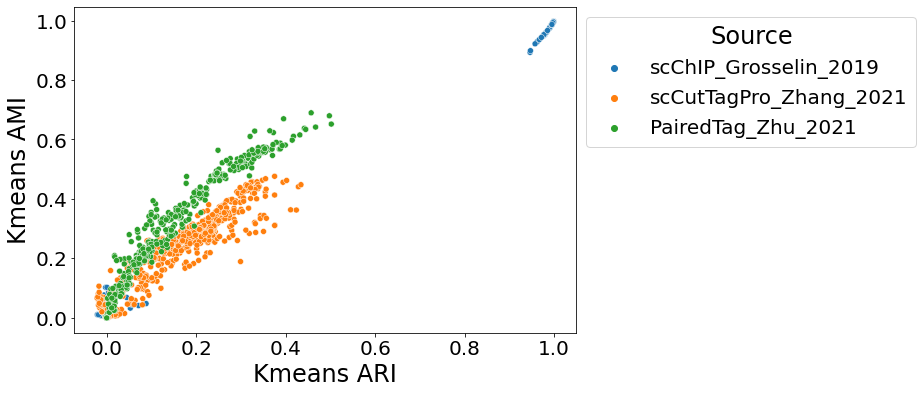

In [14]:
local = supervised[supervised['feature_selection'] == 'raw']

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharey=True)

g = sns.scatterplot(data=local,
                    ax=ax,
                    x='kmeans_ari',
                    y='kmeans_ami',
                    hue='source')

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
g.set_xlabel('Kmeans ARI', fontsize=24)
g.set_ylabel('Kmeans AMI', fontsize=24)
g.tick_params(labelsize=20)

lgd = plt.legend(
    bbox_to_anchor=(1, 1),
    ncol=1,
    loc='upper left',
    title='Source',
    fontsize=20,
    title_fontsize=24,
)

save_figure(f'FigR5_AMI_ARI_corr.pdf', lgd)
plt.show()

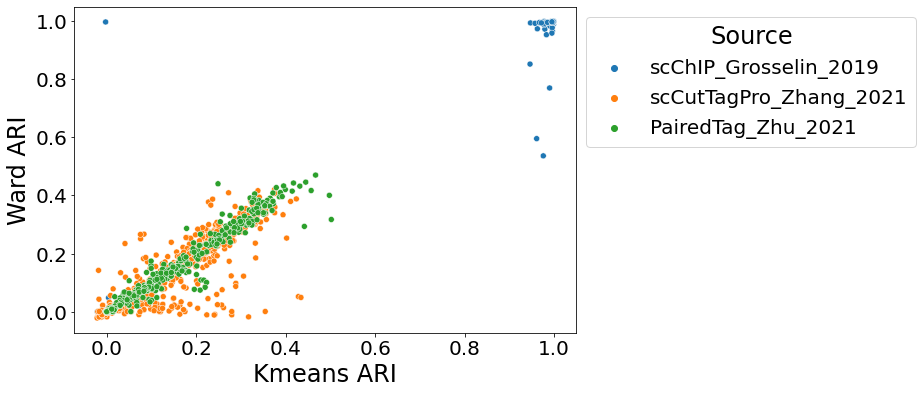

In [15]:
local = supervised[supervised['feature_selection'] == 'raw']

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharey=True)

g = sns.scatterplot(data=local,
                    ax=ax,
                    x='kmeans_ari',
                    y='ward_ari',
                    hue='source')

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
g.set_xlabel('Kmeans ARI', fontsize=24)
g.set_ylabel('Ward ARI', fontsize=24)
g.tick_params(labelsize=20)

lgd = plt.legend(
    bbox_to_anchor=(1, 1),
    ncol=1,
    loc='upper left',
    title='Source',
    fontsize=20,
    title_fontsize=24,
)

save_figure(f'FigR6_ward_kmeans_corr.pdf', lgd)
plt.show()

## Zhang and Zhu

Zhang_2021 dataset


<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


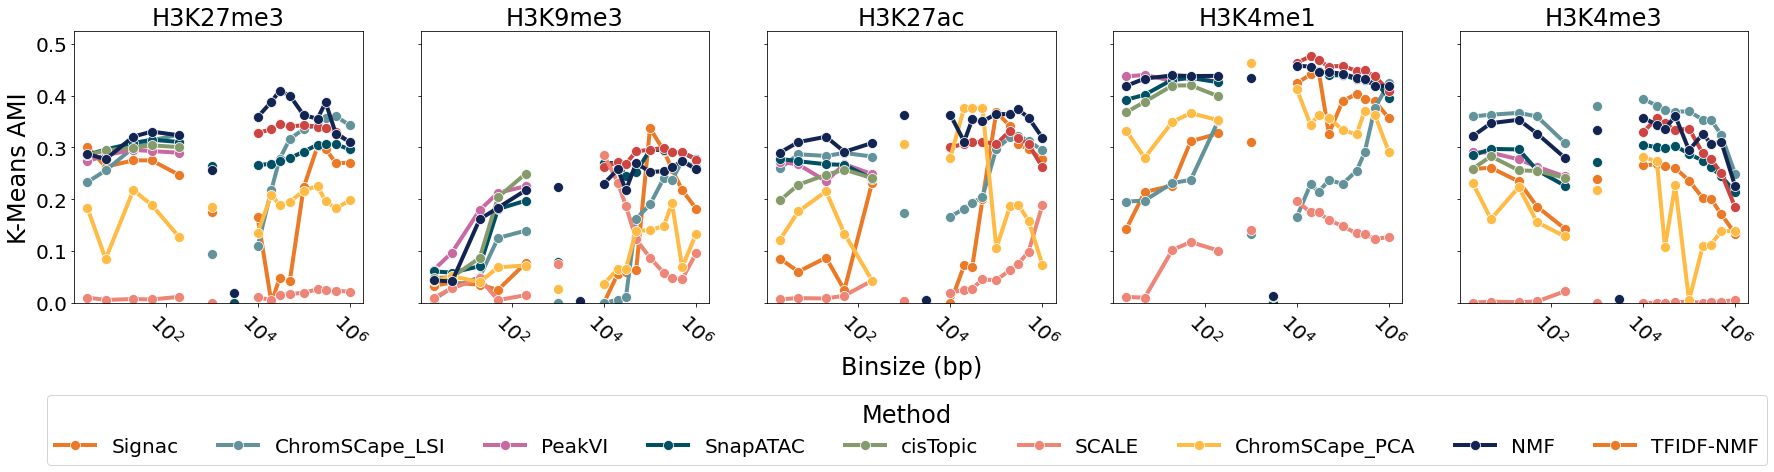

<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


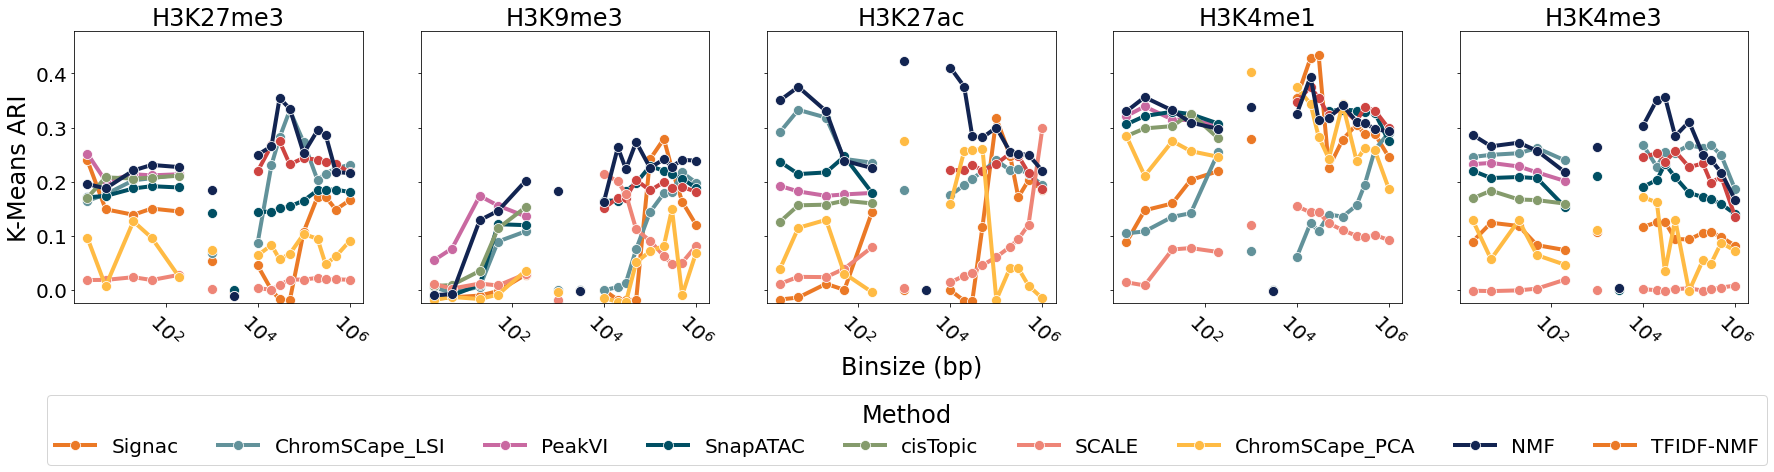

<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


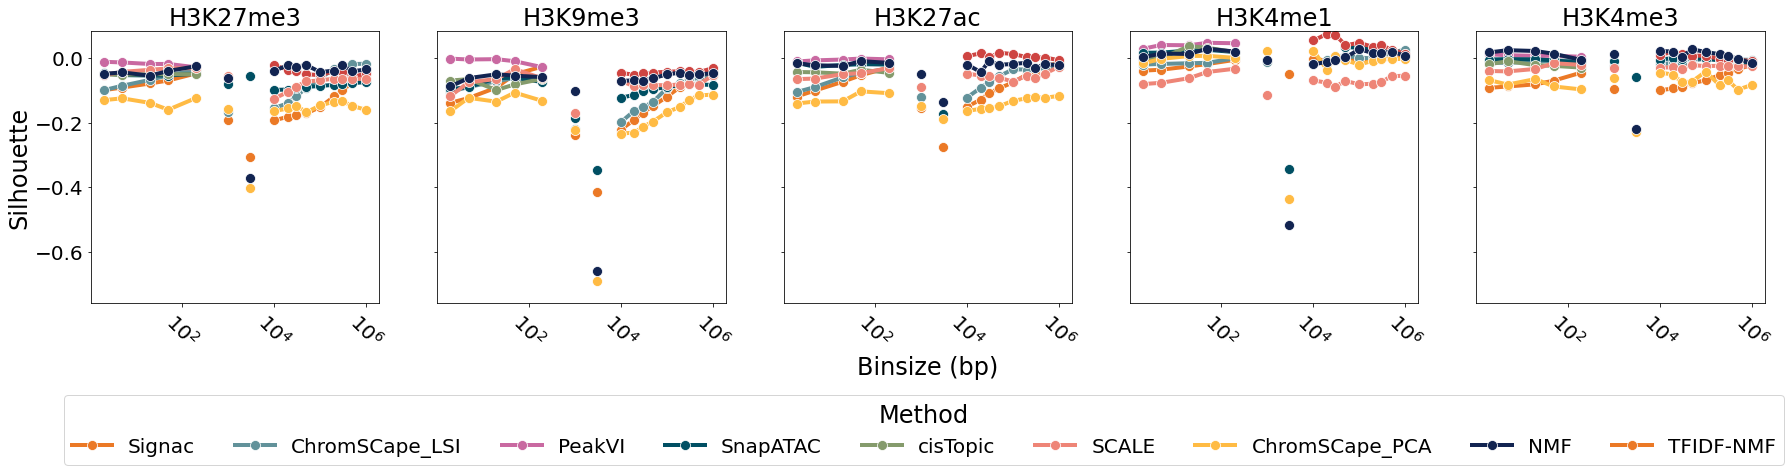

<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


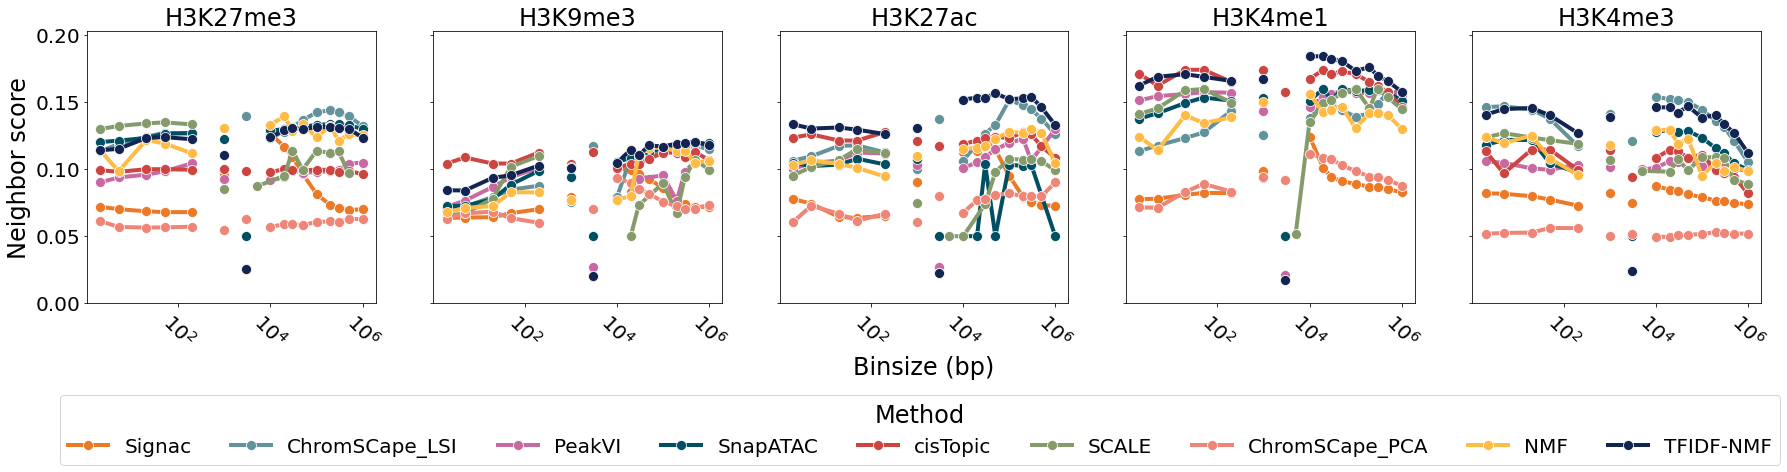

<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


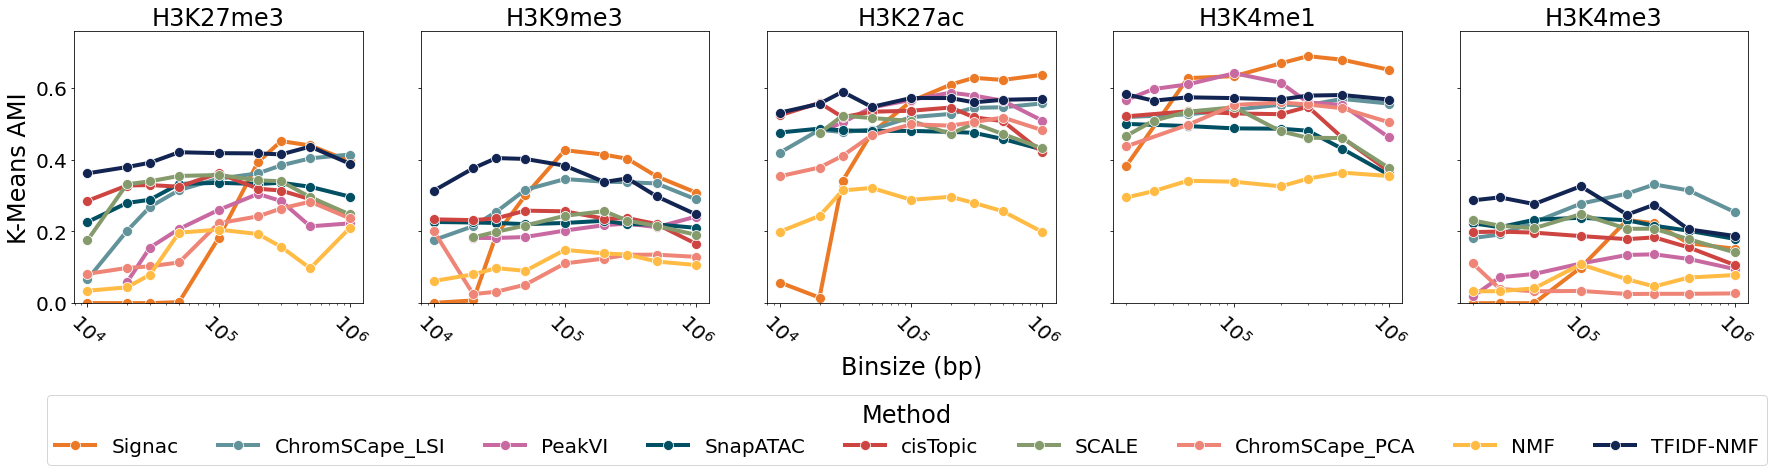

<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


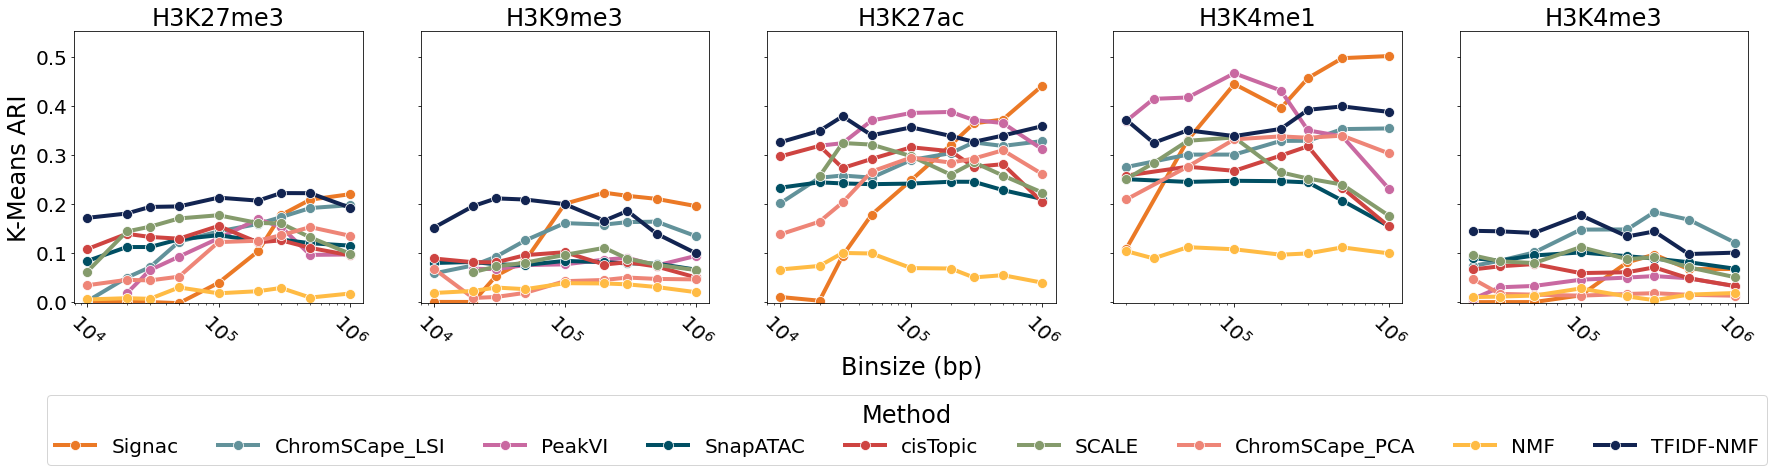

<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


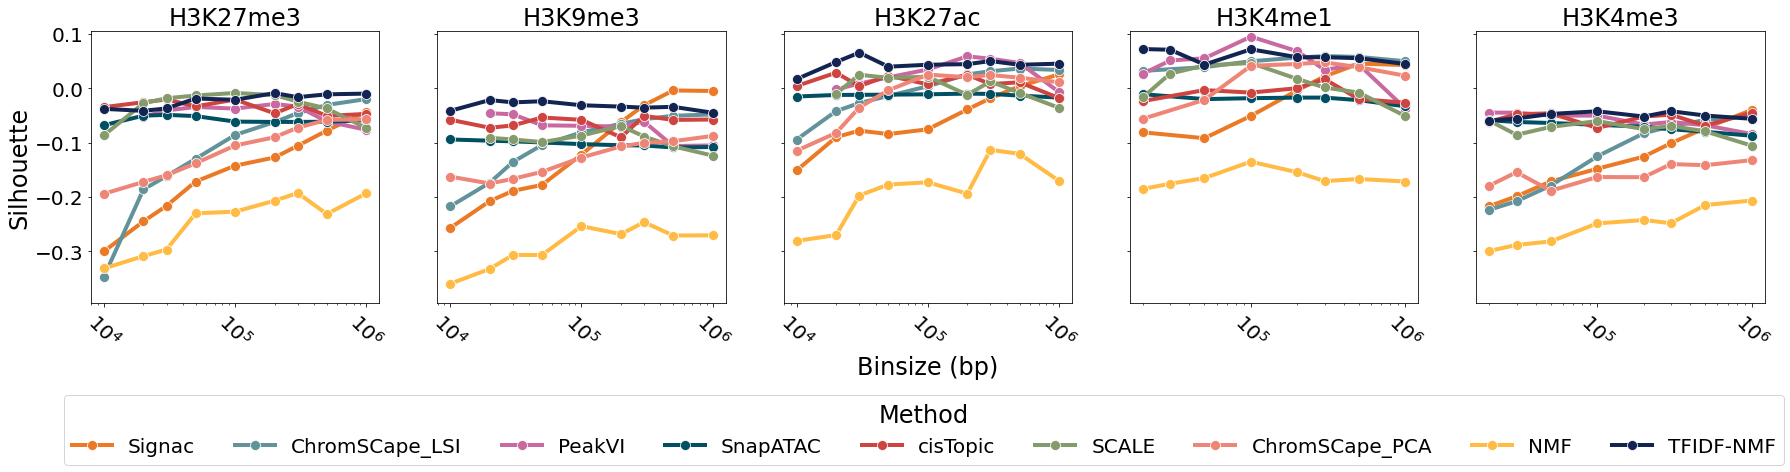

<ipython-input-16-2f5187ffaf5f>:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


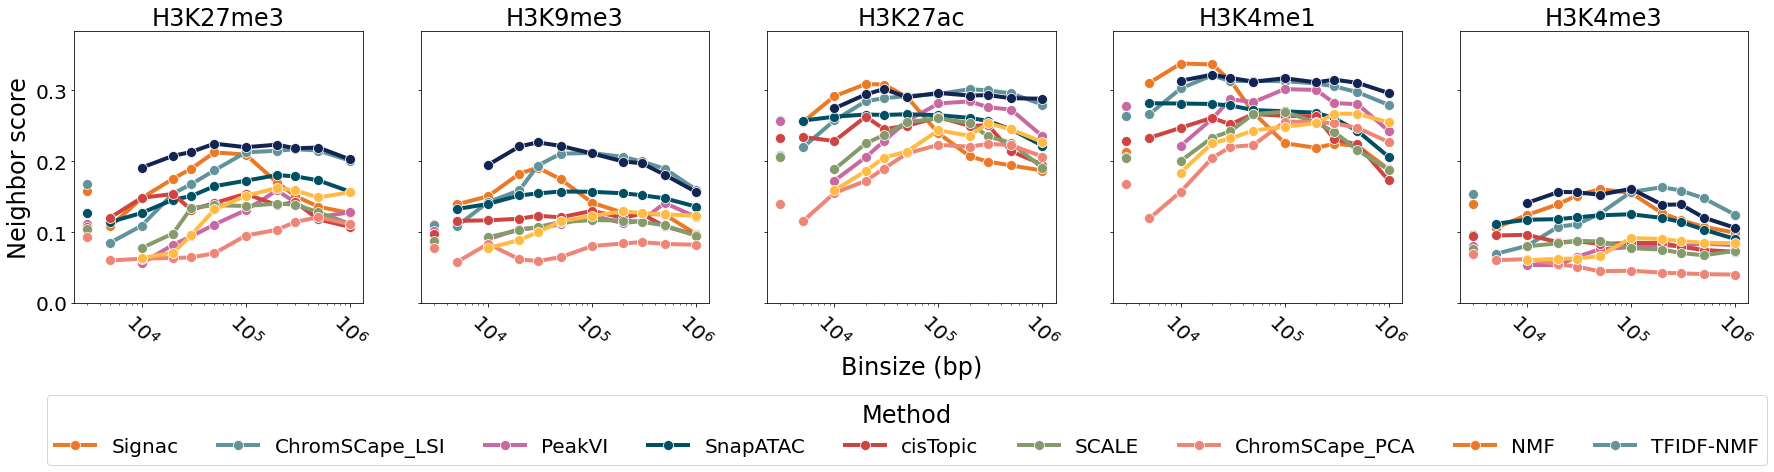

In [16]:
print('Zhang_2021 dataset')

_EXCLUDE = [x for x in _SICERS]
_EXCLUDE += ['MACS2PseudBulk', 'GeneTSS']

PLOTTING = {
    'AMI': {
      'df': supervised,
      'column': 'kmeans_ami',
      'legend': 'K-Means AMI'  
    },
    'ARI': {
      'df': supervised,
      'column': 'kmeans_ari',
      'legend': 'K-Means ARI'  
    },
    'silhouette': {
      'df': supervised,
      'column': 'silhouette',
      'legend': 'Silhouette'  
    },
    'neighbor': {
      'df': scores,
      'column': 'neighbor score',
      'legend': 'Neighbor score'  
    },
}

for source in scores['source'].unique():
  for mode in PLOTTING.keys():
    local = PLOTTING[mode]['df']
    local = local[(local['source'] == source) & (local['feature_selection']=='raw')]
    lines = []
    fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)

    y_max = local[PLOTTING[mode]['column']].max()
    y_min = local[PLOTTING[mode]['column']].min()
    for i, mark in enumerate(MARKS_ORDER):
      ax = axes[i]
      if source == 'scCutTagPro_Zhang_2021':
        g = sns.lineplot(ax=ax,
                         data=local[(local['Mark'] == mark) & (local['binsize'].map(lambda x: x in _SICERS))],
                         x='binsize_log',
                         y=PLOTTING[mode]['column'],
                         hue='Method',
                         hue_order=METHODS_ORDER,
                         palette=palette,
                         legend=False,
                         linewidth=4,
                         marker='o',
                         markersize=10,
                         dashes=False,
        )
        g = sns.lineplot(ax=ax,
                         data=local[(local['Mark'] == mark) & (local['binsize'] == 'MACS2PseudBulk')],
                         x='binsize_log',
                         y=PLOTTING[mode]['column'],
                         hue='Method',
                         hue_order=METHODS_ORDER,
                         palette=palette,
                         legend=False,
                         linewidth=4,
                         marker='o',
                         markersize=10,
                         dashes=False,
        )
      g = sns.lineplot(ax=ax,
                       data=local[(local['Mark'] == mark) & (local['binsize'] == 'GeneTSS')],
                       x='binsize_log',
                       y=PLOTTING[mode]['column'],
                       hue='Method',
                       hue_order=METHODS_ORDER,
                       palette=palette,
                       legend=False,
                       linewidth=4,
                       marker='o',
                       markersize=10,
                       dashes=False,
      )
      g = sns.lineplot(ax=ax,
                       data=local[(local['Mark'] == mark) & (local['binsize'].map(lambda x: x not in _EXCLUDE))],
                       x='binsize_log',
                       y=PLOTTING[mode]['column'],
                       hue='Method',
                       hue_order=METHODS_ORDER,
                       palette=palette,
                       legend=False,
                       linewidth=4,
                       marker='o',
                       markersize=10,
                       dashes=False,
      )

      
      g.set(xscale='log', ylim=(min(0, 1.1*y_min), 1.1*y_max))
      ax.set_title(mark, size=24)
      ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
      g.set_xlabel('')
      if i == 2:
        g.set_xlabel('Binsize (bp)', fontsize=24)
      if i == 0:
        ax.tick_params(axis='y', labelsize=20)
        g.set_ylabel(PLOTTING[mode]['legend'], fontsize=24)
      lines.append(g)

    lgd = plt.legend(
        lines,
        labels=METHODS_ORDER,
        loc='upper right',
        bbox_to_anchor=(1.1, -.3),
        ncol=math.ceil(len(METHODS_ORDER)),
        markerscale=1,
        title='Method',
        fontsize=20,
        title_fontsize=24,
    )
    save_figure(f'{source}_bins_{mode}.pdf', lgd)
    plt.show()

In [17]:
scores['source'].unique()

array(['scCutTagPro_Zhang_2021', 'PairedTag_Zhu_2021'], dtype=object)

## Grosselin

Grosselin_2019 dataset


<ipython-input-18-0ae280418e79>:38: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


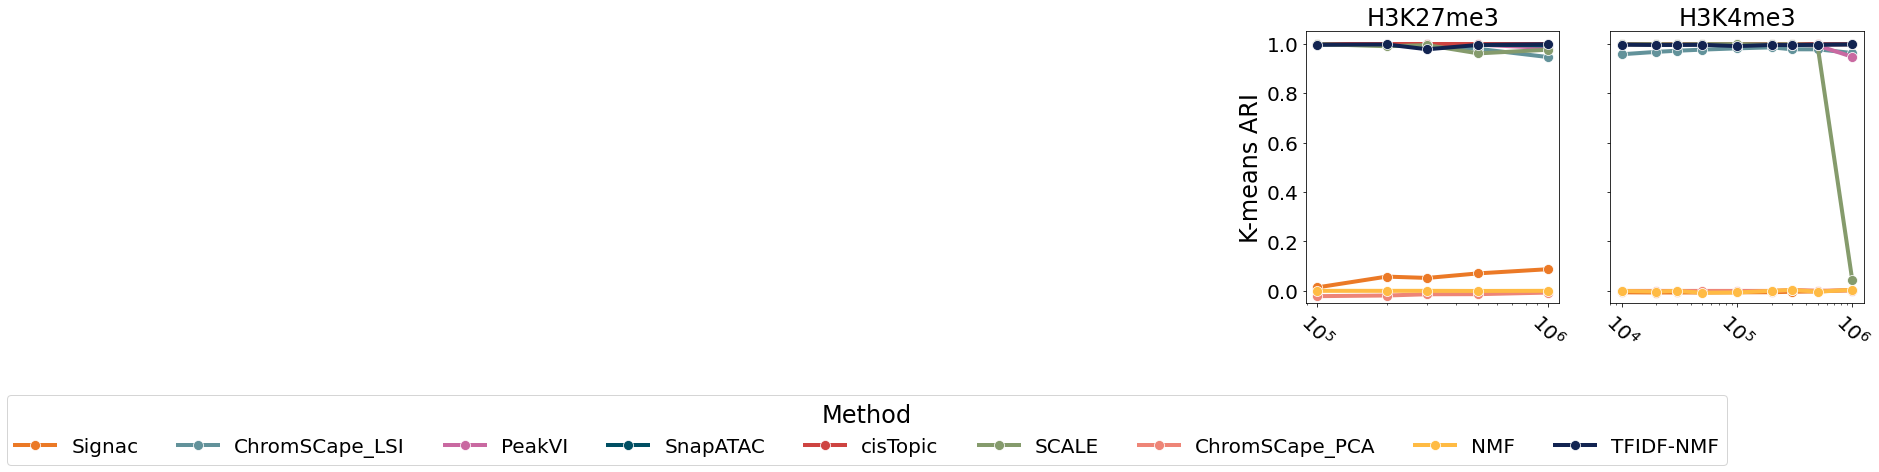

In [18]:
print('Grosselin_2019 dataset')

local = supervised[(supervised['Dataset'] == 'scChIP_Grosselin_2019') & (supervised['feature_selection']=='raw')]
lines = []
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

y_min, y_max = local['kmeans_ari'].min(), local['kmeans_ari'].max()
for i, mark in enumerate(['H3K27me3', 'H3K4me3']):
  ax = axes[i]
  g = sns.lineplot(
      ax=ax,
      data=local[(local['Mark'] == mark)],
      x='binsize_log',
      y='kmeans_ari',
      hue='Method',
      hue_order=METHODS_ORDER,
      legend=False,
      linewidth=4,
      palette=palette,
      marker='o',
      markersize=10,
      dashes=False,
      #err_style="bars", ci=68,
  )
  g.set(xscale='log', ylim=(-0.05, 1.05))
  ax.set_title(mark, size=24)
  #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
  ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
  g.set_xlabel('')
  if i == 2:
    g.set_xlabel('Binsize (bp)', fontsize=24)
  if i == 0:
    ax.tick_params(axis='y', labelsize=20)
    g.set_ylabel('K-means ARI', fontsize=24)
  lines.append(g)
#fig.suptitle(f'Role of binsize accross methods', va='top')

lgd = plt.legend(
    lines,
    labels=METHODS_ORDER,
    loc='upper right',
    bbox_to_anchor=(.5, -.3),
    ncol=math.ceil(len(METHODS_ORDER)),
    markerscale=1,
    title='Method',
    fontsize=20,
    title_fontsize=24,
)
save_figure('scChIP_Grosselin_2019_ari_bins.pdf', lgd)
plt.show()

## Neighbor gains

In [19]:
local = scores[scores['feature_selection'] == 'raw']

for source in scores['source'].unique():
  print(source)
  line = [''] + MARKS_ORDER
  print(f'{" & ".join(line)} \\\\')
  print('\\midrule')
  for method in METHODS_ORDER:
    line = [method]
    for mark in MARKS_ORDER:
      tmp = local[(local['Mark'] == mark) & (local['Method'] == method) & (local['source'] == source)]['neighbor score']
      ratio = tmp.max() / tmp.min()
      line.append(f'{ratio:.2f}')
    print(f'{" & ".join(line)} \\\\')
  print('')

scCutTagPro_Zhang_2021
 & H3K27me3 & H3K9me3 & H3K27ac & H3K4me1 & H3K4me3 \\
\midrule
Signac & 5.01 & 5.16 & 4.41 & 2.47 & 1.20 \\
ChromSCape_LSI & 1.30 & 1.68 & 1.52 & 1.39 & 1.46 \\
PeakVI & 1.16 & 3.95 & 4.76 & 7.55 & 1.10 \\
SnapATAC & 2.65 & 2.36 & 2.15 & 3.19 & 2.57 \\
cisTopic & 1.04 & 1.12 & 1.18 & 1.19 & 1.40 \\
SCALE & 1.59 & 2.19 & 2.30 & 3.10 & 1.43 \\
ChromSCape_PCA & 1.14 & 1.55 & 1.49 & 1.57 & 1.13 \\
NMF & 5.60 & 5.87 & 5.79 & 8.99 & 5.39 \\
TFIDF-NMF & 5.16 & 6.03 & 7.00 & 10.76 & 6.08 \\

PairedTag_Zhu_2021
 & H3K27me3 & H3K9me3 & H3K27ac & H3K4me1 & H3K4me3 \\
\midrule
Signac & 1.96 & 1.96 & 1.65 & 1.79 & 1.62 \\
ChromSCape_LSI & 2.54 & 1.95 & 1.37 & 1.22 & 2.35 \\
PeakVI & 2.83 & 1.57 & 1.65 & 1.36 & 1.57 \\
SnapATAC & 1.58 & 1.61 & 1.28 & 1.37 & 1.38 \\
cisTopic & 1.43 & 1.35 & 1.35 & 1.54 & 1.33 \\
SCALE & 1.80 & 1.33 & 1.38 & 1.43 & 1.30 \\
ChromSCape_PCA & 2.01 & 1.49 & 1.94 & 2.14 & 1.70 \\
NMF & 2.55 & 1.67 & 1.60 & 1.45 & 1.52 \\
TFIDF-NMF & 1.18 & 1.45 & 1.

# Plot embeddings

In [20]:
_METADATA_ZHU = None

_ADATAS_ZHU = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(dict)))
_ADATAS_RNA = dict()

def get_labels(mark):
  global _METADATA_ZHU
  if _METADATA_ZHU is None:
    with tf.io.gfile.GFile('/drive/My Drive/These/input/PairedTag_Zhu_2021/RNA/meta.tsv', 'r') as f:
      _METADATA_ZHU = pd.read_csv(f, sep='\t', index_col='Cell_ID')
  return _METADATA_ZHU

FILES = {
    'ChromSCape_LSI': 'LSI.csv',
    'ChromSCape_PCA': 'pca.csv', 
    'Signac': 'Signac.csv',
    'SnapATAC': 'SnapATAC.csv',
    'cisTopic': 'cisTopic.csv',
    'PeakVI': 'peakVI.csv',
    'SCALE': 'SCALE.csv',
}

def get_adata(mark, method, binsize, fe='raw'):
  if binsize != 'GeneTSS':
    binsize = f'{binsize}k'
  path = f'/drive/My Drive/These/embeddings/PairedTag_Zhu_2021/{mark}/{fe}/{binsize}/{FILES[method]}'
  with tf.io.gfile.GFile(path, 'r') as f:
    emb = pd.read_csv(f, index_col=0)
  adata = anndata.AnnData(X=emb)
  labels = get_labels(mark)
  adata.obs = labels.loc[adata.obs_names]
  return adata

def get_umap(mark, method, eng, fe='raw'):
  global _ADATAS_ZHU

  if (mark not in _ADATAS_ZHU) or (method not in _ADATAS_ZHU[mark]) or (fe not in _ADATAS_ZHU[mark][method]) or (eng not in _ADATAS_ZHU[mark][method][fe]):
    adata = get_adata(mark, method, eng, fe)
    sc.pp.neighbors(adata)
    umap_local(adata)
    _ADATAS_ZHU[mark][method][fe][eng] = adata

  return _ADATAS_ZHU[mark][method][fe][eng]


def process_rna(rna):
  sc.pp.calculate_qc_metrics(rna, percent_top=None, log1p=False, inplace=True)
  sc.pp.normalize_total(rna, target_sum=1e4)
  sc.pp.log1p(rna)
  sc.pp.highly_variable_genes(rna, min_mean=0.0125, max_mean=3, min_disp=0.5)
  rna = rna[:, rna.var.highly_variable]
  sc.pp.regress_out(rna, ['total_counts'])
  sc.pp.scale(rna, max_value=10)
  sc.tl.pca(rna, svd_solver='arpack')
  return rna

def get_rna_umap(mark):
  global _ADATAS_RNA

  if mark not in _ADATAS_RNA:
    path = '/drive/My Drive/These/input/PairedTag_Zhu_2021/RNA'
    with tf.io.gfile.GFile(os.path.join(path, 'matrix.mtx'), mode='rb') as f:
      matrix = scipy.io.mmread(f)
    matrix = scipy.sparse.csr_matrix(matrix)
    adata = anndata.AnnData(matrix)
    adata = adata.transpose()
    with tf.io.gfile.GFile(os.path.join(path, 'barcodes.tsv'), mode='r') as f:
      barcodes = pd.read_csv(f, sep='\t', header=None)[0]
    adata.obs_names = barcodes
    with tf.io.gfile.GFile(os.path.join(path, 'genes.tsv'), mode='r') as f:
      bins = pd.read_csv(f, sep='\t', header=None)[0]
    adata.var_names = bins
    with tf.io.gfile.GFile(os.path.join(path, 'meta.tsv'), mode='r') as f:
      meta = pd.read_csv(f, sep='\t', index_col='Cell_ID')
    adata.obs = meta
    adata = adata[adata.obs['Target'] == mark]
    adata = process_rna(adata)
    sc.pp.neighbors(adata)
    umap_local(adata)
    _ADATAS_RNA[mark] = adata

  return _ADATAS_RNA[mark]

Local implementation of scanpy needed because of https://github.com/scverse/scanpy/issues/1978

In [21]:
from typing import Optional, Union
import warnings

import numpy as np
from packaging import version
from anndata import AnnData
from sklearn.utils import check_random_state, check_array

from scanpy.tools._utils import get_init_pos_from_paga, _choose_representation
import scanpy.logging as logg
from scanpy._settings import settings
from scanpy._compat import Literal
from scanpy._utils import AnyRandom, NeighborsView


_InitPos = Literal['paga', 'spectral', 'random']


def umap_local(
    adata: AnnData,
    min_dist: float = 0.5,
    spread: float = 1.0,
    n_components: int = 2,
    maxiter: Optional[int] = None,
    alpha: float = 1.0,
    gamma: float = 1.0,
    negative_sample_rate: int = 5,
    init_pos: Union[_InitPos, np.ndarray, None] = 'spectral',
    random_state: AnyRandom = 0,
    a: Optional[float] = None,
    b: Optional[float] = None,
    copy: bool = False,
    method: Literal['umap', 'rapids'] = 'umap',
    neighbors_key: Optional[str] = None,
) -> Optional[AnnData]:
    """\
    Embed the neighborhood graph using UMAP [McInnes18]_.
    UMAP (Uniform Manifold Approximation and Projection) is a manifold learning
    technique suitable for visualizing high-dimensional data. Besides tending to
    be faster than tSNE, it optimizes the embedding such that it best reflects
    the topology of the data, which we represent throughout Scanpy using a
    neighborhood graph. tSNE, by contrast, optimizes the distribution of
    nearest-neighbor distances in the embedding such that these best match the
    distribution of distances in the high-dimensional space.  We use the
    implementation of `umap-learn <https://github.com/lmcinnes/umap>`__
    [McInnes18]_. For a few comparisons of UMAP with tSNE, see this `preprint
    <https://doi.org/10.1101/298430>`__.
    Parameters
    ----------
    adata
        Annotated data matrix.
    min_dist
        The effective minimum distance between embedded points. Smaller values
        will result in a more clustered/clumped embedding where nearby points on
        the manifold are drawn closer together, while larger values will result
        on a more even dispersal of points. The value should be set relative to
        the ``spread`` value, which determines the scale at which embedded
        points will be spread out. The default of in the `umap-learn` package is
        0.1.
    spread
        The effective scale of embedded points. In combination with `min_dist`
        this determines how clustered/clumped the embedded points are.
    n_components
        The number of dimensions of the embedding.
    maxiter
        The number of iterations (epochs) of the optimization. Called `n_epochs`
        in the original UMAP.
    alpha
        The initial learning rate for the embedding optimization.
    gamma
        Weighting applied to negative samples in low dimensional embedding
        optimization. Values higher than one will result in greater weight
        being given to negative samples.
    negative_sample_rate
        The number of negative edge/1-simplex samples to use per positive
        edge/1-simplex sample in optimizing the low dimensional embedding.
    init_pos
        How to initialize the low dimensional embedding. Called `init` in the
        original UMAP. Options are:
        * Any key for `adata.obsm`.
        * 'paga': positions from :func:`~scanpy.pl.paga`.
        * 'spectral': use a spectral embedding of the graph.
        * 'random': assign initial embedding positions at random.
        * A numpy array of initial embedding positions.
    random_state
        If `int`, `random_state` is the seed used by the random number generator;
        If `RandomState` or `Generator`, `random_state` is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.
    a
        More specific parameters controlling the embedding. If `None` these
        values are set automatically as determined by `min_dist` and
        `spread`.
    b
        More specific parameters controlling the embedding. If `None` these
        values are set automatically as determined by `min_dist` and
        `spread`.
    copy
        Return a copy instead of writing to adata.
    method
        Use the original 'umap' implementation, or 'rapids' (experimental, GPU only)
    neighbors_key
        If not specified, umap looks .uns['neighbors'] for neighbors settings
        and .obsp['connectivities'] for connectivities
        (default storage places for pp.neighbors).
        If specified, umap looks .uns[neighbors_key] for neighbors settings and
        .obsp[.uns[neighbors_key]['connectivities_key']] for connectivities.
    Returns
    -------
    Depending on `copy`, returns or updates `adata` with the following fields.
    **X_umap** : `adata.obsm` field
        UMAP coordinates of data.
    """
    adata = adata.copy() if copy else adata

    if neighbors_key is None:
        neighbors_key = 'neighbors'

    if neighbors_key not in adata.uns:
        raise ValueError(
            f'Did not find .uns["{neighbors_key}"]. Run `sc.pp.neighbors` first.'
        )
    start = logg.info('computing UMAP')

    neighbors = NeighborsView(adata, neighbors_key)

    if 'params' not in neighbors or neighbors['params']['method'] != 'umap':
        logg.warning(
            f'.obsp["{neighbors["connectivities_key"]}"] have not been computed using umap'
        )

    # Compat for umap 0.4 -> 0.5
    with warnings.catch_warnings():
        # umap 0.5.0
        warnings.filterwarnings("ignore", message=r"Tensorflow not installed")
        import umap

    if version.parse(pkg_resources.get_distribution("umap-learn").version) >= version.parse("0.5.0"):

        def simplicial_set_embedding(*args, **kwargs):
            from umap.umap_ import simplicial_set_embedding

            X_umap, _ = simplicial_set_embedding(
                *args,
                densmap=False,
                densmap_kwds={},
                output_dens=False,
                **kwargs,
            )
            return X_umap

    else:
        from umap.umap_ import simplicial_set_embedding
    from umap.umap_ import find_ab_params

    if a is None or b is None:
        a, b = find_ab_params(spread, min_dist)
    else:
        a = a
        b = b
    adata.uns['umap'] = {'params': {'a': a, 'b': b}}
    if isinstance(init_pos, str) and init_pos in adata.obsm.keys():
        init_coords = adata.obsm[init_pos]
    elif isinstance(init_pos, str) and init_pos == 'paga':
        init_coords = get_init_pos_from_paga(
            adata, random_state=random_state, neighbors_key=neighbors_key
        )
    else:
        init_coords = init_pos  # Let umap handle it
    if hasattr(init_coords, "dtype"):
        init_coords = check_array(init_coords, dtype=np.float32, accept_sparse=False)

    if random_state != 0:
        adata.uns['umap']['params']['random_state'] = random_state
    random_state = check_random_state(random_state)

    neigh_params = neighbors['params']
    X = _choose_representation(
        adata,
        neigh_params.get('use_rep', None),
        neigh_params.get('n_pcs', None),
        silent=True,
    )
    if method == 'umap':
        # the data matrix X is really only used for determining the number of connected components
        # for the init condition in the UMAP embedding
        default_epochs = 500 if neighbors['connectivities'].shape[0] <= 10000 else 200
        n_epochs = default_epochs if maxiter is None else maxiter
        X_umap = simplicial_set_embedding(
            X,
            neighbors['connectivities'].tocoo(),
            n_components,
            alpha,
            a,
            b,
            gamma,
            negative_sample_rate,
            n_epochs,
            init_coords,
            random_state,
            neigh_params.get('metric', 'euclidean'),
            neigh_params.get('metric_kwds', {}),
            verbose=settings.verbosity > 3,
        )
    elif method == 'rapids':
        metric = neigh_params.get('metric', 'euclidean')
        if metric != 'euclidean':
            raise ValueError(
                f'`sc.pp.neighbors` was called with `metric` {metric!r}, '
                "but umap `method` 'rapids' only supports the 'euclidean' metric."
            )
        from cuml import UMAP

        n_neighbors = neighbors['params']['n_neighbors']
        n_epochs = (
            500 if maxiter is None else maxiter
        )  # 0 is not a valid value for rapids, unlike original umap
        X_contiguous = np.ascontiguousarray(X, dtype=np.float32)
        umap = UMAP(
            n_neighbors=n_neighbors,
            n_components=n_components,
            n_epochs=n_epochs,
            learning_rate=alpha,
            init=init_pos,
            min_dist=min_dist,
            spread=spread,
            negative_sample_rate=negative_sample_rate,
            a=a,
            b=b,
            verbose=settings.verbosity > 3,
            random_state=random_state,
        )
        X_umap = umap.fit_transform(X_contiguous)
    adata.obsm['X_umap'] = X_umap  # annotate samples with UMAP coordinates
    logg.info(
        '    finished',
        time=start,
        deep=('added\n' "    'X_umap', UMAP coordinates (adata.obsm)"),
    )
    return adata if copy else None

In [22]:
best = scores[(scores['source'] == 'PairedTag_Zhu_2021') & (scores['feature_selection'] == 'raw')]
best['keep'] = best['Method'].map(lambda x: x in METHODS_ORDER)
best = best[best['keep']]
best = best[best['Method'] == 'ChromSCape_LSI']
best = best.groupby(by=['Mark'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))

best

<ipython-input-22-bd7fa5df33fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best['keep'] = best['Method'].map(lambda x: x in METHODS_ORDER)


neighbor score      AULC       Avg              source      Mark  \
0 4954         0.217011  0.124642  0.136306  PairedTag_Zhu_2021  H3K27me3   
1 15548        0.211665  0.127020  0.138206  PairedTag_Zhu_2021   H3K9me3   
2 1351         0.301617  0.181234  0.196947  PairedTag_Zhu_2021   H3K27ac   
3 8408         0.320915  0.194617  0.210331  PairedTag_Zhu_2021   H3K4me1   
4 12154        0.163517  0.086389  0.099063  PairedTag_Zhu_2021   H3K4me3   

                 Method feature_selection binsize binsize_raw  binsize_log  \
0 4954   ChromSCape_LSI               raw  300kbp         300     300000.0   
1 15548  ChromSCape_LSI               raw  100kbp         100     100000.0   
2 1351   ChromSCape_LSI               raw  200kbp         200     200000.0   
3 8408   ChromSCape_LSI               raw   20kbp          20      20000.0   
4 12154  ChromSCape_LSI               raw  200kbp         200     200000.0   

         keep  
0 4954   True  
1 15548  True  
2 1351   True  
3 8408   True  
4 12154  True

## Embeddings

Role of matrix construction

In [23]:
if PLOT_UMAPS:

  fig, axes = plt.subplots(1, 4, figsize=(32, 7))
  lines = []

  for i, eng in enumerate([20, 300]):
    for j, mark in enumerate(['H3K4me1', 'H3K27me3']):
      ax = axes[i + 2*j]
      adata = get_umap(mark, 'ChromSCape_LSI', eng, fe='raw')
      labels = adata.obs['Annotation'].unique()
      for label in labels:
        lines.append(ax.scatter(
            x=adata.obsm['X_umap'][adata.obs['Annotation'] == label,0],
            y=adata.obsm['X_umap'][adata.obs['Annotation'] == label,1],
            s=6,
            label=label,
        ))
      ax.axes.xaxis.set_visible(False)
      ax.axes.yaxis.set_visible(False)
      #ax.set_title(f'UMAP of ChromSCape_LSI with {eng}kbp bins', fontsize=30)

  lgd = plt.legend(
      lines,
      labels=labels,
      loc='upper right',
      bbox_to_anchor=(0.5, -0.1),
      ncol=len(labels) // 3,
      markerscale=7,
      title='Cell type',
      fontsize=20,
      title_fontsize=24,
  )
  plt.show()

Standard dataset stuff

In [24]:
%%time
if PLOT_UMAPS:
  # Precompute the umaps.
  for mark in MARKS_ORDER:
    _ = get_rna_umap(mark)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [25]:
if PLOT_UMAPS:

  fig, axes = plt.subplots(1, 5, figsize=(40, 7))
  lines = []

  for i, mark in enumerate(MARKS_ORDER):
    ax = axes[i]
    adata = get_rna_umap(mark)
    labels = adata.obs['Annotation'].unique()
    for label in labels:
      lines.append(ax.scatter(
          x=adata.obsm['X_umap'][adata.obs['Annotation'] == label,0],
          y=adata.obsm['X_umap'][adata.obs['Annotation'] == label,1],
          s=6,
          label=label,
      ))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #ax.set_title(f'UMAP of ChromSCape_LSI with {eng}kbp bins', fontsize=30)

  '''
  lgd = plt.legend(
      lines,
      labels=labels,
      loc='upper right',
      bbox_to_anchor=(0.5, -0.1),
      ncol=len(labels) // 2,
      markerscale=7,
      title='Cell type',
      fontsize=20,
      title_fontsize=24,
  )
  '''
  plt.show()

In [26]:
if PLOT_UMAPS:

  best_chromscape = scores[(scores['source'] == 'PairedTag_Zhu_2021') & (scores['feature_selection'] == 'raw')].groupby(by=['Mark', 'Method'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))
  best_chromscape = best_chromscape[best_chromscape['Method'] == 'ChromSCape_LSI']
  best_bs = dict()
  for record in best_chromscape.to_records():
    best_bs[record['Mark']] = int(record['binsize_log'] / 1000)

  fig, axes = plt.subplots(1, 5, figsize=(40, 7))
  lines = []

  for i, mark in enumerate(MARKS_ORDER):
    ax = axes[i]
    adata = get_umap(mark, 'ChromSCape_LSI', best_bs[mark], fe='raw')
    labels = adata.obs['Annotation'].unique()
    for label in labels:
      lines.append(ax.scatter(
          x=adata.obsm['X_umap'][adata.obs['Annotation'] == label,0],
          y=adata.obsm['X_umap'][adata.obs['Annotation'] == label,1],
          s=6,
          label=label,
      ))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #ax.set_title(f'UMAP of ChromSCape_LSI with {eng}kbp bins', fontsize=30)

  lgd = plt.legend(
      lines,
      labels=labels,
      loc='upper right',
      bbox_to_anchor=(1.1, -0.1),
      ncol=len(labels) // 2,
      markerscale=7,
      title='Cell type',
      fontsize=24,
      title_fontsize=30,
  )
  plt.show()

# Compare best performances

## Supervised

scChIP_Grosselin_2019


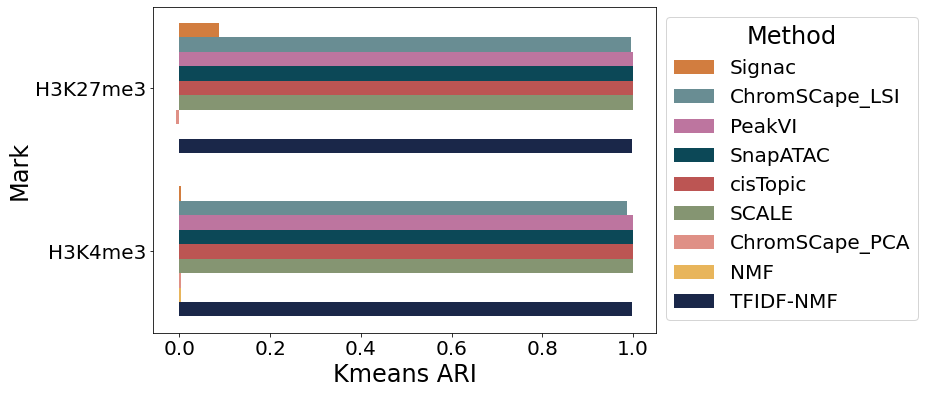

scCutTagPro_Zhang_2021


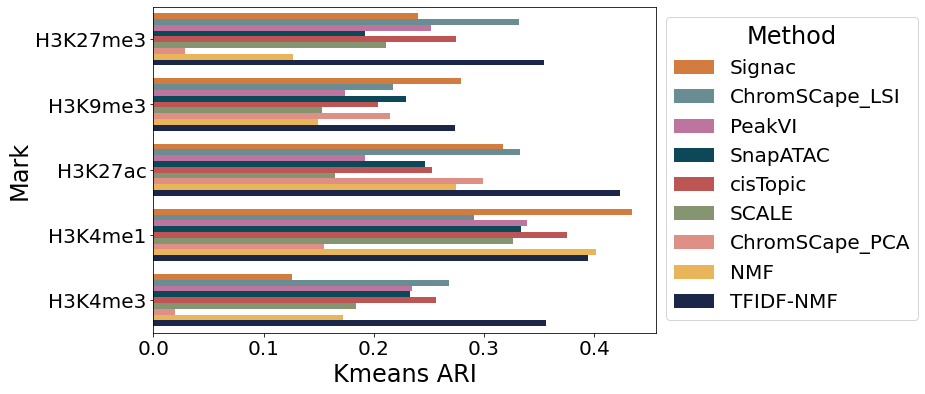

PairedTag_Zhu_2021


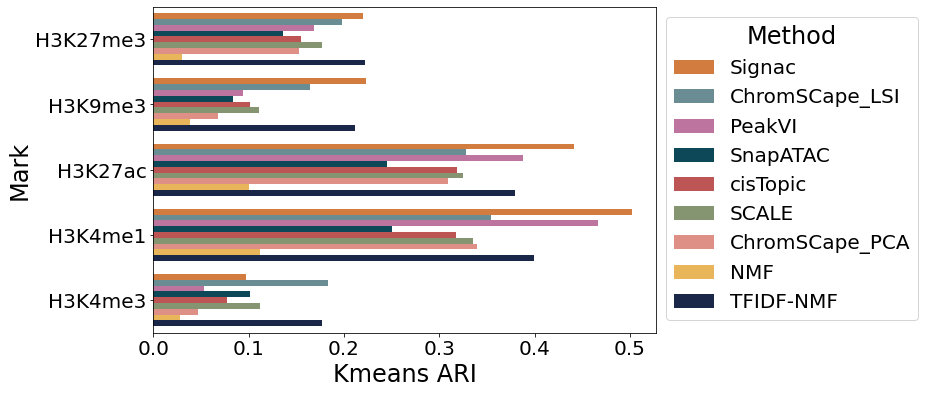

In [27]:
for source in supervised['Dataset'].unique():
  print(source)
  best = supervised[(supervised['Dataset'] == source) & (supervised['feature_selection'] == 'raw')].groupby(by=['Mark', 'Method'], as_index=False).apply(lambda x: x.sort_values(['kmeans_ari'], ascending=False).head(1))
  best['keep'] = best['Method'].map(lambda x: x in METHODS_ORDER)
  best = best[best['keep']]
  if source == 'scChIP_Grosselin_2019':
    best['Mark'] = pd.Categorical(best['Mark'],
                                  categories=['H3K27me3', 'H3K4me3'],
                                  ordered=True)
  fig, axes = plt.subplots(1, 1, figsize=(9, 6))
  g = sns.barplot(data=best,
                  ax=axes,
                  y='Mark',
                  x='kmeans_ari',
                  hue='Method',
                  hue_order=METHODS_ORDER,
                  palette=palette,
                  #y_order=MARKS_ORDER,
  )
  plt.setp(axes.get_legend().get_texts(), fontsize='20') # for legend text
  plt.setp(axes.get_legend().get_title(), fontsize='20') # for legend title
  g.set_xlabel('Kmeans ARI', fontsize=24)
  g.set_ylabel('Mark', fontsize=24)
  g.tick_params(labelsize=20)

  lgd = plt.legend(
      bbox_to_anchor=(1, 1),
      ncol=1,
      loc='upper left',
      title='Method',
      fontsize=20,
      title_fontsize=24,
  )

  save_figure(f'{source}_raw_benchmark_ari.pdf', lgd)
  plt.show()

## Neighbor

scCutTagPro_Zhang_2021


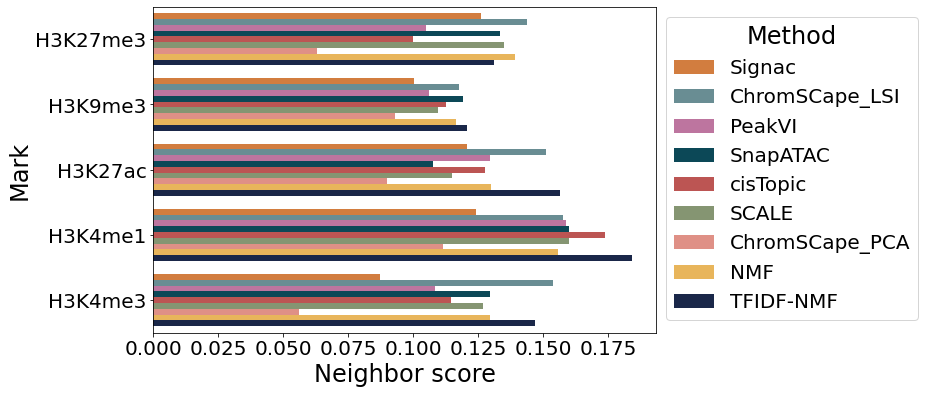

PairedTag_Zhu_2021


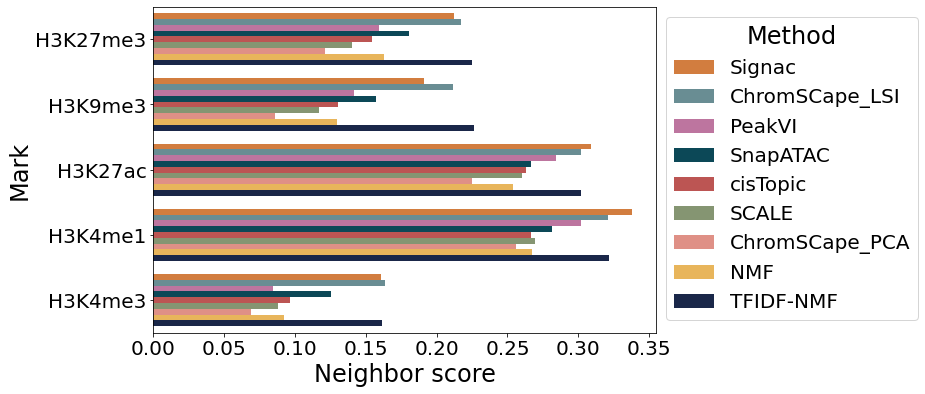

In [28]:
for source in scores['source'].unique():
  best = scores[(scores['source'] == source) & (scores['feature_selection'] == 'raw')].groupby(by=['Mark', 'Method'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))
  best['keep'] = best['Method'].map(lambda x: x in METHODS_ORDER)
  best = best[best['keep']]

  fig, axes = plt.subplots(1, 1, figsize=(9, 6))
  g = sns.barplot(data=best,
                  ax=axes,
                  y='Mark',
                  x='neighbor score',
                  hue='Method',
                  hue_order=METHODS_ORDER,
                  palette=palette,
                  #y_order=MARKS_ORDER,
  )
  plt.setp(axes.get_legend().get_texts(), fontsize='20') # for legend text
  plt.setp(axes.get_legend().get_title(), fontsize='20') # for legend title
  g.set_xlabel('Neighbor score', fontsize=24)
  g.set_ylabel('Mark', fontsize=24)
  g.tick_params(labelsize=20)

  lgd = plt.legend(
      bbox_to_anchor=(1, 1),
      ncol=1,
      loc='upper left',
      title='Method',
      fontsize=20,
      title_fontsize=24,
  )

  save_figure(f'{source}_raw_benchmark.pdf', lgd)
  print(source)
  plt.show()

In [29]:
local = scores[(scores['feature_selection'] == 'raw')].groupby(by=['Mark', 'Method', 'source'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))
local['keep'] = local['Method'].map(lambda x: x in METHODS_ORDER)
local = local[local['keep']]

print('\\begin{tabular}{|l|r|r|r|r|r|}')
print('\\hline')
print('\\multirow{2}{*}{Method} & \multicolumn{5}{c|}{neighbor score} \\\\')
print(f'\\cline{{2-6}} & {" & ".join(MARKS_ORDER)} \\\\')
print('\\hline')

for method in METHODS_ORDER:
  acc = [method]
  for ds in local['source'].unique():
    if ds == 'scCutTagPro_Zhang_2021':
      continue
    for mark in MARKS_ORDER:
      if mark == 'H3K4me2':
        continue
      tmp = local[(local['Mark']==mark) &
                  (local['source']==ds) &
                  (local['Method']==method)].to_dict()
      tmp = list(tmp['neighbor score'].values())
      assert(len(tmp)==1)
      acc.append(f'{tmp[0]:.3f}')
  print(f'{" & ".join(acc)} \\\\')

\begin{tabular}{|l|r|r|r|r|r|}
\hline
\multirow{2}{*}{Method} & \multicolumn{5}{c|}{neighbor score} \\
\cline{2-6} & H3K27me3 & H3K9me3 & H3K27ac & H3K4me1 & H3K4me3 \\
\hline
Signac & 0.213 & 0.191 & 0.309 & 0.338 & 0.161 \\
ChromSCape_LSI & 0.217 & 0.212 & 0.302 & 0.321 & 0.164 \\
PeakVI & 0.159 & 0.141 & 0.284 & 0.302 & 0.084 \\
SnapATAC & 0.180 & 0.157 & 0.266 & 0.282 & 0.125 \\
cisTopic & 0.154 & 0.130 & 0.263 & 0.267 & 0.096 \\
SCALE & 0.140 & 0.117 & 0.261 & 0.270 & 0.088 \\
ChromSCape_PCA & 0.121 & 0.086 & 0.225 & 0.256 & 0.069 \\
NMF & 0.163 & 0.129 & 0.254 & 0.267 & 0.092 \\
TFIDF-NMF & 0.225 & 0.227 & 0.302 & 0.322 & 0.161 \\


In [30]:
print('Mouse brain')

local = scores[(scores['feature_selection'] == 'raw') & (scores['source'] == 'PairedTag_Zhu_2021')].groupby(by=['Mark', 'Method'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))
local['keep'] = local['Method'].map(lambda x: x in METHODS_ORDER)
local = local[local['keep']]

for mark in MARKS_ORDER:
  tmp = local[local['Mark'] == mark]['neighbor score']
  print(f'{mark} {np.mean(tmp):.3f} {np.std(tmp):.3f}')


print('Human PBMC')

local = scores[(scores['feature_selection'] == 'raw') & (scores['source'] == 'scCutTagPro_Zhang_2021')].groupby(by=['Mark', 'Method'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))
local['keep'] = local['Method'].map(lambda x: x in METHODS_ORDER)
local = local[local['keep']]

for mark in MARKS_ORDER:
  tmp = local[local['Mark'] == mark]['neighbor score']
  print(f'{mark} {np.mean(tmp):.3f} {np.std(tmp):.3f}')

Mouse brain
H3K27me3 0.175 0.034
H3K9me3 0.155 0.044
H3K27ac 0.274 0.026
H3K4me1 0.291 0.028
H3K4me3 0.116 0.036
Human PBMC
H3K27me3 0.120 0.025
H3K9me3 0.111 0.009
H3K27ac 0.125 0.019
H3K4me1 0.154 0.021
H3K4me3 0.117 0.029


In [31]:
best_all = scores[scores['feature_selection'] == 'raw'].groupby(by=['Mark', 'Method', 'source'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))
best_all['keep'] = best_all['Method'].map(lambda x: x in METHODS_ORDER)
best_all = best_all[best_all['keep']]

In [32]:
print('all')

print(f'& {" & ".join(METHODS_ORDER)} \\\\')
print('\\hline')

for x in METHODS_ORDER:
  acc = [x]
  for y in METHODS_ORDER:
    if x == y:
      acc.append(' ')
      continue
    w, p = scipy.stats.wilcoxon(x=best_all[best_all['Method'] == x]['neighbor score'], y=best_all[best_all['Method'] == y]['neighbor score'], alternative='greater')
    if p < 0.05:
      acc.append(f'\\textbf{{{p:.4f}}}')
    else:
      acc.append(f'{p:.4f}')
  print(f'{" & ".join(acc)} \\\\')

print('mouse brain')
local = best_all[best_all['source'] == 'PairedTag_Zhu_2021']

print(f'& {" & ".join(METHODS_ORDER)} \\\\')
print('\\hline')

for x in METHODS_ORDER:
  acc = [x]
  for y in METHODS_ORDER:
    if x == y:
      acc.append(' ')
      continue
    w, p = scipy.stats.wilcoxon(x=local[local['Method'] == x]['neighbor score'], y=local[local['Method'] == y]['neighbor score'], alternative='greater')
    if p < 0.05:
      acc.append(f'\\textbf{{{p:.4f}}}')
    else:
      acc.append(f'{p:.4f}')
  print(f'{" & ".join(acc)} \\\\')

all
& Signac & ChromSCape_LSI & PeakVI & SnapATAC & cisTopic & SCALE & ChromSCape_PCA & NMF & TFIDF-NMF \\
\hline
Signac &   & 0.9863 & 0.0654 & 0.2158 & 0.0801 & 0.0967 & \textbf{0.0010} & 0.1162 & 0.9814 \\
ChromSCape_LSI & \textbf{0.0186} &   & \textbf{0.0020} & \textbf{0.0049} & \textbf{0.0029} & \textbf{0.0020} & \textbf{0.0010} & \textbf{0.0010} & 0.8623 \\
PeakVI & 0.9473 & 0.9990 &   & 0.8623 & 0.3848 & 0.2783 & \textbf{0.0010} & 0.5771 & 1.0000 \\
SnapATAC & 0.8125 & 0.9971 & 0.1611 &   & \textbf{0.0322} & \textbf{0.0244} & \textbf{0.0010} & 0.0801 & 0.9980 \\
cisTopic & 0.9346 & 0.9980 & 0.6523 & 0.9756 &   & 0.1875 & \textbf{0.0010} & 0.6875 & 1.0000 \\
SCALE & 0.9199 & 0.9990 & 0.7539 & 0.9814 & 0.8389 &   & \textbf{0.0010} & 0.9346 & 0.9990 \\
ChromSCape_PCA & 1.0000 & 1.0000 & 1.0000 & 1.0000 & 1.0000 & 1.0000 &   & 1.0000 & 1.0000 \\
NMF & 0.9033 & 1.0000 & 0.4609 & 0.9346 & 0.3477 & 0.0801 & \textbf{0.0010} &   & 0.9980 \\
TFIDF-NMF & \textbf{0.0244} & 0.1611 & \textbf{

In [33]:
print('PairedTag_Zhu_2021')

local = best_all[best_all['source'] == 'PairedTag_Zhu_2021']
for x in MARKS_ORDER:
  acc = [x]
  for y in MARKS_ORDER:
    if x == y:
      acc.append(' ')
      continue
    w, p = scipy.stats.wilcoxon(x=local[local['Mark'] == x]['neighbor score'], y=local[local['Mark'] == y]['neighbor score'], alternative='greater')
    if p < 0.05:
      acc.append(f'\\textbf{{{p:.4f}}}')
    else:
      acc.append(f'{p:.4f}')
  print(f'{" & ".join(acc)} \\\\')

print('scCutTagPro_Zhang_2021')

local = best_all[best_all['source'] == 'scCutTagPro_Zhang_2021']
for x in MARKS_ORDER:
  acc = [x]
  for y in MARKS_ORDER:
    if x == y:
      acc.append(' ')
      continue
    w, p = scipy.stats.wilcoxon(x=local[local['Mark'] == x]['neighbor score'], y=local[local['Mark'] == y]['neighbor score'], alternative='greater')
    if p < 0.05:
      acc.append(f'\\textbf{{{p:.4f}}}')
    else:
      acc.append(f'{p:.4f}')
  print(f'{" & ".join(acc)} \\\\')

PairedTag_Zhu_2021
H3K27me3 &   & \textbf{0.0039} & 1.0000 & 1.0000 & \textbf{0.0020} \\
H3K9me3 & 0.9980 &   & 1.0000 & 1.0000 & \textbf{0.0020} \\
H3K27ac & \textbf{0.0020} & \textbf{0.0020} &   & 1.0000 & \textbf{0.0020} \\
H3K4me1 & \textbf{0.0020} & \textbf{0.0020} & \textbf{0.0020} &   & \textbf{0.0020} \\
H3K4me3 & 1.0000 & 1.0000 & 1.0000 & 1.0000 &   \\
scCutTagPro_Zhang_2021
H3K27me3 &   & 0.1504 & 0.8203 & 0.9980 & 0.5000 \\
H3K9me3 & 0.8750 &   & 0.9902 & 1.0000 & 0.8496 \\
H3K27ac & 0.2129 & \textbf{0.0137} &   & 1.0000 & 0.1504 \\
H3K4me1 & \textbf{0.0039} & \textbf{0.0020} & \textbf{0.0020} &   & \textbf{0.0020} \\
H3K4me3 & 0.5449 & 0.1797 & 0.8750 & 1.0000 &   \\


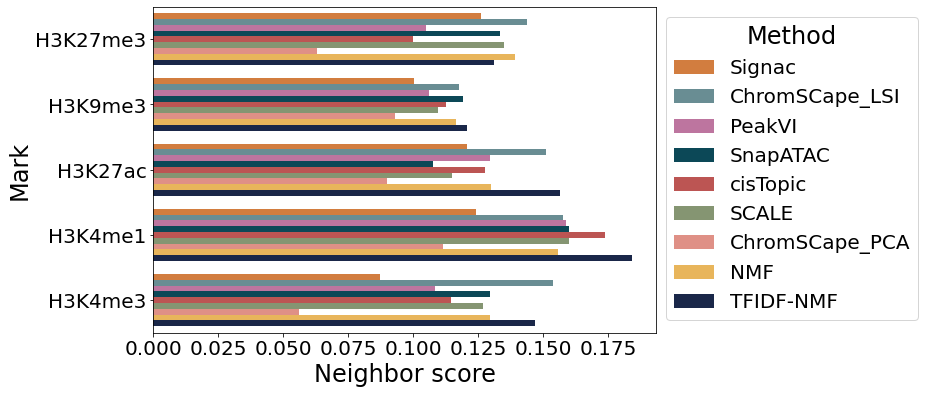

In [34]:
local = scores[(scores['source'] == 'scCutTagPro_Zhang_2021') & (scores['feature_selection'] == 'raw')].groupby(by=['Mark', 'Method'], as_index=False).apply(lambda x: x.sort_values(['neighbor score'], ascending=False).head(1))
local['keep'] = local['Method'].map(lambda x: x in METHODS_ORDER)
local = local[local['keep']]

fig, axes = plt.subplots(1, 1, figsize=(9, 6))
g = sns.barplot(data=local,
            ax=axes,
            y='Mark',
            x='neighbor score',
            hue='Method',
            hue_order=METHODS_ORDER,
            palette=palette,
            #y_order=MARKS_ORDER,
)
plt.setp(axes.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(axes.get_legend().get_title(), fontsize='20') # for legend title
g.set_xlabel('Neighbor score', fontsize=24)
g.set_ylabel('Mark', fontsize=24)
g.tick_params(labelsize=20)

lgd = plt.legend(
    bbox_to_anchor=(1, 1),
    ncol=1,
    loc='upper left',
    title='Method',
    fontsize=20,
    title_fontsize=24,
)

save_figure('raw_data_citeseq.pdf', lgd)
plt.show()

In [35]:
local.groupby(by=['Mark']).mean()

neighbor score      AULC       Avg    binsize_log
Mark                                                       
H3K27me3        0.119605  0.061812  0.072094  238894.444444
H3K9me3         0.110582  0.053868  0.064808  324466.666667
H3K27ac         0.125381  0.063165  0.074643  297788.888889
H3K4me1         0.153936  0.078005  0.091630  191111.111111
H3K4me3         0.116899  0.056620  0.068257   20006.111111

# Number of cells effect

In [36]:
NICE_NAMES_CELLS = {
    'raw' : '100%',
    'sampled_cell_p_80': '80%',
    'sampled_cell_p_60': '60%',
    'sampled_cell_p_40': '40%',
    'sampled_cell_p_20': '20%',
}


local = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
local = local[local['feature_selection'].map(lambda x: x in NICE_NAMES_CELLS)]
local['Condition'] = local['feature_selection'].map(lambda x: NICE_NAMES_CELLS[x])
local['Condition'] = pd.Categorical(local['Condition'],
                                   categories=['20%', '40%', '60%', '80%', '100%'],
                                   ordered=True)
cells_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()

<ipython-input-36-009467aa9a4b>:16: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  cells_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()


In [37]:
NUMBER_OF_CELLS = {
  'H3K4me1': 12962,
  'H3K4me3': 7465,
  'H3K9me3': 12044,
  'H3K27ac': 11749,
  'H3K27me3': 6534,
}


def compute_n_cells(mark, condition):
  p = float(condition[:-1]) / 100
  return p * NUMBER_OF_CELLS[mark]


np.mean(list(NUMBER_OF_CELLS.values())) / 2 

5075.4

<ipython-input-38-4ab212ea056b>:38: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


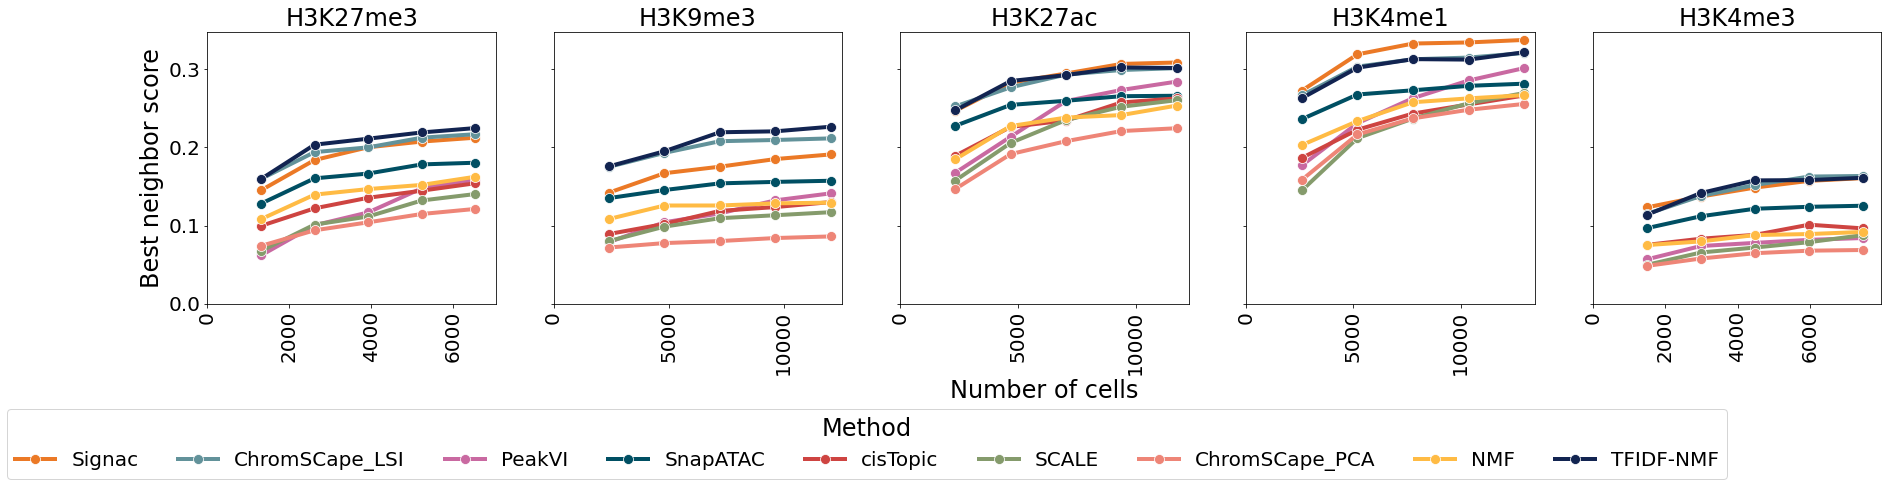

In [38]:
lines = []
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)

y_min, y_max = cells_effect['neighbor score'].min(), cells_effect['neighbor score'].max()
cells_effect['n_cells'] = cells_effect.apply(lambda x: compute_n_cells(x['Mark'], x['Condition']), axis=1)

for i, mark in enumerate(MARKS_ORDER):
  ax = axes[i]
  g= sns.lineplot(data=cells_effect[cells_effect['Mark'] == mark],
                  ax=ax,
                  x='n_cells',
                  y='neighbor score',
                  hue='Method',
                  hue_order=METHODS_ORDER,
                  legend=False,
                  palette=palette,
                  linewidth=4,
                  marker='o',
                  markersize=10,
                  dashes=False,
                  )
  g.set(ylim=(0, y_max), xlim=(0, NUMBER_OF_CELLS[mark] + 500))
  #g.set(xscale='log', ylim=(0, ylim))
  ax.set_title(mark, size=24)
  #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
  ax.tick_params(axis='x', labelrotation = 90, labelsize=20)
  g.set_xlabel('')
  if i == 2:
    g.set_xlabel('Number of cells', fontsize=24)
  if i == 0:
    ax.tick_params(axis='y', labelsize=20)
    g.set_ylabel('Best neighbor score', fontsize=24)



  lines.append(g)
#fig.suptitle(f'Effect of the number of cells', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=METHODS_ORDER,
    loc='upper right',
    bbox_to_anchor=(.5, -.35),
    ncol=math.ceil(len(METHODS_ORDER)),
    markerscale=1,
    title='Method',
    fontsize=20,
    title_fontsize=24,
)
save_figure('cells_effect.pdf', lgd)

plt.show()

In [39]:
def filter_n_cells(fe):
  prefix = 'sampled_cell_n_'
  return fe[:len(prefix)] == prefix

def parse_n_cells(fe):
  prefix = 'sampled_cell_n_'
  n = fe[len(prefix):]
  return(int(n))


local = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
local = local[local['feature_selection'].map(filter_n_cells)]
local['n_cells'] = local['feature_selection'].map(parse_n_cells)

n_cells_effect = local.groupby(['Mark', 'Method', 'n_cells'], as_index=False).max()

<ipython-input-40-92aafc9ad852>:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


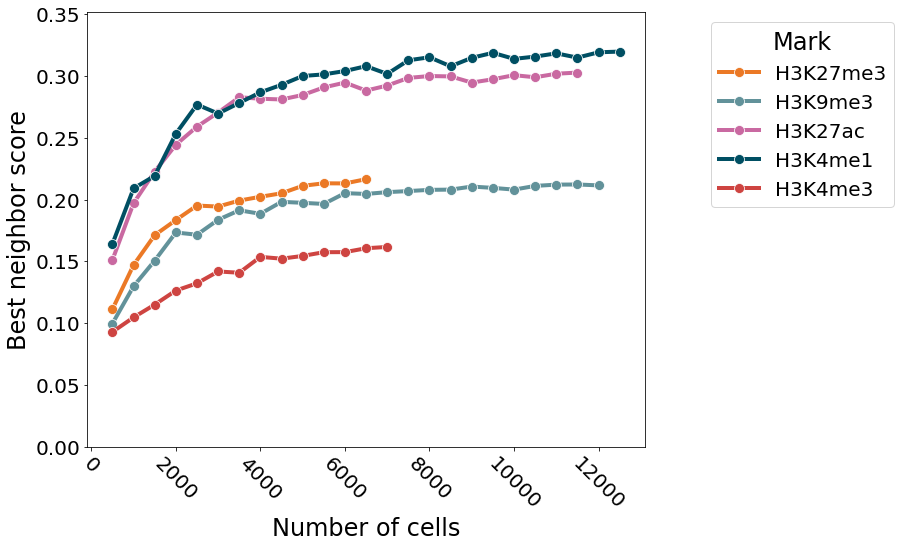

In [40]:
lines = []
fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharey=True)

y_min, y_max = n_cells_effect['neighbor score'].min(), n_cells_effect['neighbor score'].max()

g= sns.lineplot(data=n_cells_effect,
                  ax=ax,
                  x='n_cells',
                  y='neighbor score',
                  hue='Mark',
                  hue_order=MARKS_ORDER,
                  #legend=False,
                  palette=palette[:len(MARKS_ORDER)],
                  linewidth=4,
                  marker='o',
                  markersize=10,
                  dashes=False,
                  )
g.set(ylim=(0, 1.1*y_max))
#g.set(xscale='log', ylim=(0, ylim))
#ax.set_title(mark, size=24)
#ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
g.set_xlabel('')
g.set_xlabel('Number of cells', fontsize=24)
ax.tick_params(axis='y', labelsize=20)
g.set_ylabel('Best neighbor score', fontsize=24)



lines.append(g)
#fig.suptitle(f'Effect of the number of cells', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=MARKS_ORDER,
    loc='upper left',
    bbox_to_anchor=(1.1, 1),
    ncol=1,
    markerscale=1,
    title='Mark',
    fontsize=20,
    title_fontsize=24,
)
save_figure('cells_effect_chromscape.pdf', lgd)

plt.show()

## Table

In [41]:
acc = []

for method in METHODS_ORDER:
  for mark in MARKS_ORDER:
    tmp = cells_effect[(cells_effect['Mark'] == mark) & (cells_effect['Method'] == method)]
    high = list(tmp[tmp['Condition'] == '100%'].to_dict()['neighbor score'].values())[0]
    vlow = list(tmp[tmp['Condition'] == '40%'].to_dict()['neighbor score'].values())[0]
    low = list(tmp[tmp['Condition'] == '60%'].to_dict()['neighbor score'].values())[0]
    acc.append({'Method': method, 'Mark': mark, 'From 40%': (high - vlow) / vlow, 'From 60%': (high - low) / low})

gains = pd.DataFrame(acc)
print(gains[(gains['Method'] == 'Signac') | (gains['Method'] == 'ChromSCape_LSI')].to_latex())
#print(gains.groupby('Mark').mean().to_latex())
#print(gains.groupby('Method').mean().to_latex())

\begin{tabular}{lllrr}
\toprule
{} &          Method &      Mark &  From 40\% &  From 60\% \\
\midrule
0 &          Signac &  H3K27me3 &  0.155517 &  0.061261 \\
1 &          Signac &   H3K9me3 &  0.143947 &  0.089379 \\
2 &          Signac &   H3K27ac &  0.091621 &  0.047746 \\
3 &          Signac &   H3K4me1 &  0.057750 &  0.013829 \\
4 &          Signac &   H3K4me3 &  0.172040 &  0.081887 \\
5 &  ChromSCape\_LSI &  H3K27me3 &  0.118224 &  0.084206 \\
6 &  ChromSCape\_LSI &   H3K9me3 &  0.096083 &  0.017392 \\
7 &  ChromSCape\_LSI &   H3K27ac &  0.088770 &  0.028116 \\
8 &  ChromSCape\_LSI &   H3K4me1 &  0.057024 &  0.025371 \\
9 &  ChromSCape\_LSI &   H3K4me3 &  0.185670 &  0.075866 \\
\bottomrule
\end{tabular}



# Coverage effect

In [42]:
NICE_NAMES_COVERAGE = {
        'raw': 'all',
        'filtered_cell_baseline': 'baseline',
        'filtered_cell_q_0_50': 'q0_q50',
        'filtered_cell_q_10_60': 'q10_q60',
        'filtered_cell_q_20_70': 'q20_q70',
        'filtered_cell_q_30_80': 'q30_q80',
        'filtered_cell_q_40_90': 'q40_q90',
        'filtered_cell_q_50_100': 'q50_q100',
}

local = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
local = local[local['feature_selection'].map(lambda x: x in NICE_NAMES_COVERAGE)]
local['Condition'] = local['feature_selection'].map(lambda x: NICE_NAMES_COVERAGE[x])
local['Condition'] = pd.Categorical(local['Condition'],
                                   categories=['all', 'baseline', 'q0_q50', 'q10_q60', 'q20_q70', 'q30_q80', 'q40_q90', 'q50_q100',],
                                   ordered=True)
coverage_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()

<ipython-input-42-422a40cde6d5>:18: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  coverage_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()


<ipython-input-43-59b314cf830f>:37: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


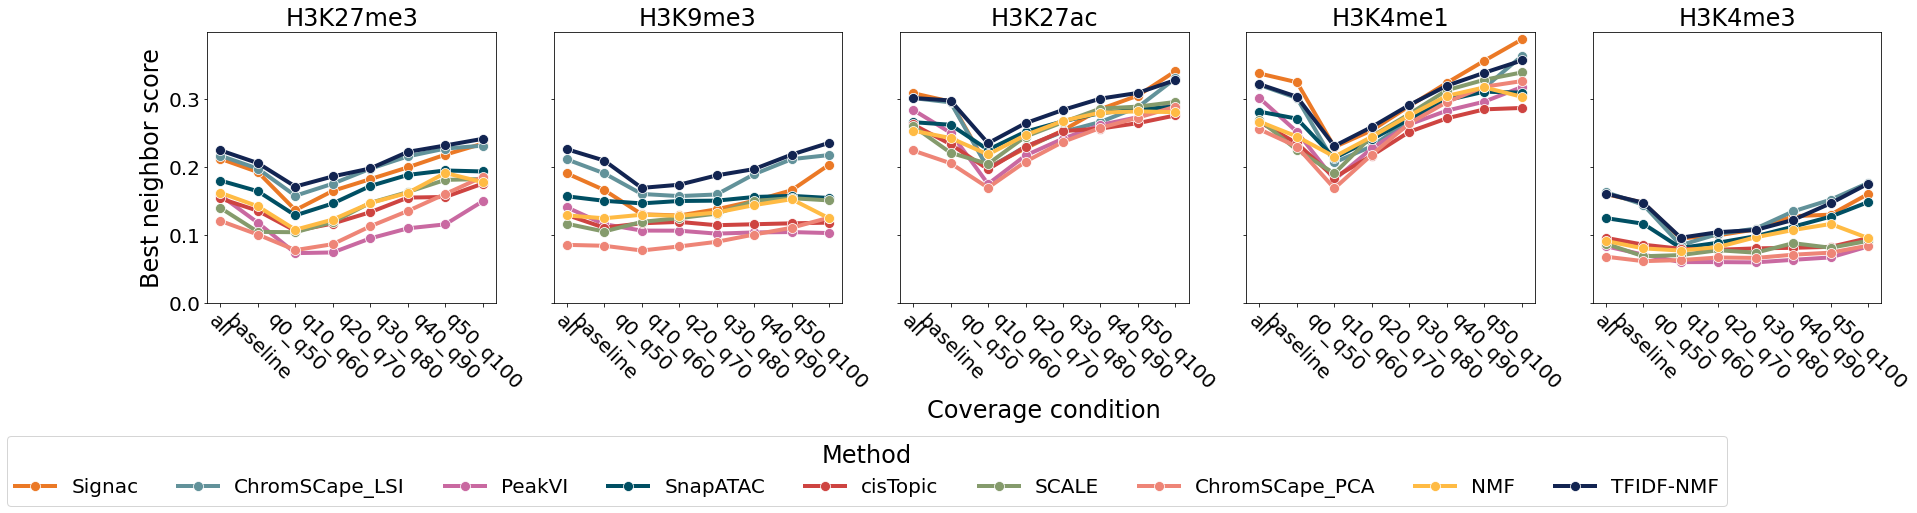

In [43]:
lines = []
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)

y_min, y_max = coverage_effect['neighbor score'].min(), coverage_effect['neighbor score'].max()

for i, mark in enumerate(MARKS_ORDER):
  ax = axes[i]
  g= sns.lineplot(data=coverage_effect[coverage_effect['Mark'] == mark],
                  ax=ax,
                  x='Condition',
                  y='neighbor score',
                  hue='Method',
                  hue_order=METHODS_ORDER,
                  legend=False,
                  palette=palette,
                  linewidth=4,
                  marker='o',
                  markersize=10,
                  dashes=False,
                  )
  g.set(ylim=(0, y_max))
  #g.set(xscale='log', ylim=(0, ylim))
  ax.set_title(mark, size=24)
  #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
  ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
  g.set_xlabel('')
  if i == 2:
      g.set_xlabel('Coverage condition', fontsize=24)
  if i == 0:
    ax.tick_params(axis='y', labelsize=20)
    g.set_ylabel('Best neighbor score', fontsize=24)



  lines.append(g)
#fig.suptitle(f'Effect of the coverage per cell', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=METHODS_ORDER,
    loc='upper right',
    bbox_to_anchor=(0.5, -.45),
    ncol=math.ceil(len(METHODS_ORDER)),
    markerscale=1,
    title='Method',
    fontsize=20,
    title_fontsize=24,
)
save_figure('coverage_effect.pdf', lgd)

plt.show()

## Table

In [44]:
acc = []

for method in METHODS_ORDER:
  for mark in MARKS_ORDER:
    tmp = coverage_effect[(coverage_effect['Mark'] == mark) & (coverage_effect['Method'] == method)]
    high = list(tmp[tmp['Condition'] == 'q50_q100'].to_dict()['neighbor score'].values())[0]
    low = list(tmp[tmp['Condition'] == 'baseline'].to_dict()['neighbor score'].values())[0]
    vlow = list(tmp[tmp['Condition'] == 'q0_q50'].to_dict()['neighbor score'].values())[0]
    acc.append({'Method': method, 'Mark': mark, 'large increase': (high - vlow) / vlow, 'baseline': (high - low) / low})

gains = pd.DataFrame(acc)
print(gains[(gains['Method'] == 'Signac') | (gains['Method'] == 'ChromSCape_LSI')].to_latex())
#print(gains.groupby('Method').mean().to_latex())

\begin{tabular}{lllrr}
\toprule
{} &          Method &      Mark &  large increase &  baseline \\
\midrule
0 &          Signac &  H3K27me3 &        0.711169 &  0.216195 \\
1 &          Signac &   H3K9me3 &        0.555214 &  0.223105 \\
2 &          Signac &   H3K27ac &        0.708079 &  0.150955 \\
3 &          Signac &   H3K4me1 &        0.688159 &  0.193250 \\
4 &          Signac &   H3K4me3 &        0.682831 &  0.087547 \\
5 &  ChromSCape\_LSI &  H3K27me3 &        0.464776 &  0.170427 \\
6 &  ChromSCape\_LSI &   H3K9me3 &        0.355167 &  0.140428 \\
7 &  ChromSCape\_LSI &   H3K27ac &        0.666558 &  0.119091 \\
8 &  ChromSCape\_LSI &   H3K4me1 &        0.754959 &  0.204230 \\
9 &  ChromSCape\_LSI &   H3K4me3 &        1.067144 &  0.220442 \\
\bottomrule
\end{tabular}



<ipython-input-45-96d1a15fa052>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local['Method'] = pd.Categorical(local['Method'],


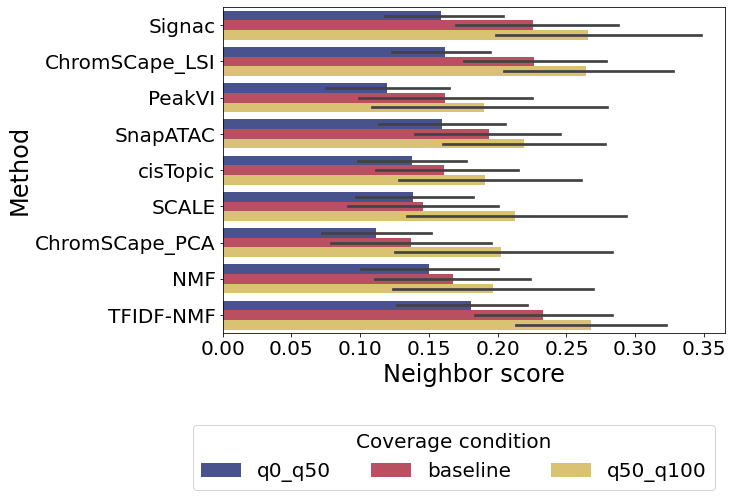

In [45]:
local_palette = met_brew('Klimt', n=6)
local_palette.append(met_brew('Cross', n=7)[6])

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

local = coverage_effect[coverage_effect['Method'].map(lambda x: x in METHODS_ORDER)]
local['Method'] = pd.Categorical(local['Method'],
                                  categories=METHODS_ORDER,
                                  ordered=True)

g = sns.barplot(data=local,
                ax=ax,
                y='Method',
                x='neighbor score',
                hue='Condition',
                hue_order=['q0_q50', 'baseline', 'q50_q100'],
                palette=local_palette,
                #palette=palette,
            #y_order=MARKS_ORDER,
)

lgd = plt.legend(
    bbox_to_anchor=(1, -.25),
    ncol=3,
    loc='upper right',
    title='Coverage condition',
    fontsize=20,
    title_fontsize=24,
)

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
g.set_xlabel('Neighbor score', fontsize=24)
g.set_ylabel('Method', fontsize=24)
g.tick_params(labelsize=20)

save_figure('coverage_gains.pdf', lgd)
plt.show()


<ipython-input-46-fe508f8b4bdf>:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


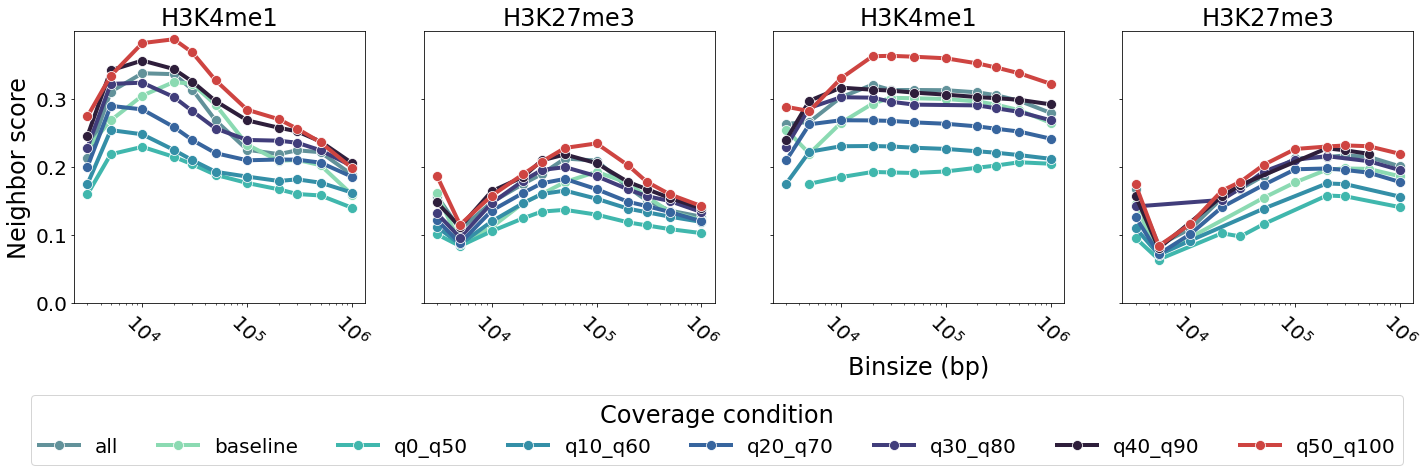

In [46]:
gradient_coverage = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
gradient_coverage = gradient_coverage[gradient_coverage['feature_selection'].map(lambda x: x in NICE_NAMES_COVERAGE)]
gradient_coverage['Condition'] = gradient_coverage['feature_selection'].map(lambda x: NICE_NAMES_COVERAGE[x])

gradient_coverage['Condition'] = pd.Categorical(gradient_coverage['Condition'],
                                   categories=['all', 'baseline', 'q0_q50', 'q10_q60', 'q20_q70', 'q30_q80', 'q40_q90', 'q50_q100',],
                                   ordered=True)

y_min, y_max = gradient_coverage['neighbor score'].min(), gradient_coverage['neighbor score'].max()


lines = []
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)
for i, mark in enumerate(['H3K4me1', 'H3K27me3']):
  for j, method in enumerate(['Signac', 'ChromSCape_LSI']):
    ax=axes[i + j*2]
    g = sns.lineplot(data=gradient_coverage[(gradient_coverage['Mark'] == mark) & (gradient_coverage['Method']==method)],
                x='binsize_log',
                y='neighbor score',
                hue='Condition',
                ax=ax,
                legend=False,
                palette=[palette[1]] + list(sns.color_palette("mako_r", len(gradient_coverage['Condition'].unique())-2)) + [palette[4]], #sns.color_palette("mako_r", len(gradient_coverage['Condition'].unique())),
                linewidth=4,
                marker='o',
                markersize=10,
                dashes=False,
                )
    g.set(xscale='log', ylim=(0, y_max))
    #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
    g.set_xlabel('')
    ax.set_title(mark, size=24)
    if (i + j*2) == 2:
      g.set_xlabel('Binsize (bp)', fontsize=24)
    if i == 0:
      ax.tick_params(axis='y', labelsize=20)
      g.set_ylabel('Neighbor score', fontsize=24)
    lines.append(g)

#fig.suptitle(f'Effect of the coverage per cell', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=gradient_coverage['Condition'].unique(),
    loc='upper right',
    bbox_to_anchor=(1, -0.3),
    ncol=len(gradient_coverage['Condition'].unique()),
    markerscale=1,
    title='Coverage condition',
    fontsize=20,
    title_fontsize=24,
)

save_figure('coverage_gradient.pdf', lgd)
plt.show()

## Embeddings

In [47]:
k4m1_bs_selection = scores[(scores['source'] == 'PairedTag_Zhu_2021') & (scores['Mark'] == 'H3K4me1') & (scores['Method'] == 'ChromSCape_LSI')]
k4m1_bs_selection = k4m1_bs_selection[k4m1_bs_selection['feature_selection'].map(lambda x: x in ['filtered_cell_baseline', 'filtered_cell_q_0_50', 'filtered_cell_q_50_100'])]
k4m1_bs_selection['Condition'] = k4m1_bs_selection['feature_selection'].map(lambda x: NICE_NAMES_COVERAGE[x])
k4m1_bs_selection = k4m1_bs_selection[k4m1_bs_selection['binsize'] == '30kbp']
k4m1_bs_selection

neighbor score      AULC       Avg              source     Mark  \
8421        0.301713  0.178651  0.194531  PairedTag_Zhu_2021  H3K4me1   
8443        0.192084  0.114818  0.123580  PairedTag_Zhu_2021  H3K4me1   
8540        0.363331  0.215897  0.234715  PairedTag_Zhu_2021  H3K4me1   

              Method       feature_selection binsize binsize_raw  binsize_log  \
8421  ChromSCape_LSI  filtered_cell_baseline   30kbp          30      30000.0   
8443  ChromSCape_LSI    filtered_cell_q_0_50   30kbp          30      30000.0   
8540  ChromSCape_LSI  filtered_cell_q_50_100   30kbp          30      30000.0   

     Condition  
8421  baseline  
8443    q0_q50  
8540  q50_q100

In [48]:
if PLOT_UMAPS:

  fig, axes = plt.subplots(1, 3, figsize=(24, 7))
  lines = []

  for i, record in enumerate(k4m1_bs_selection.to_records()):
    ax = axes[i]
    bs = int(record["binsize_log"] / 1000)
    adata = get_umap(record['Mark'], record['Method'], bs, record['feature_selection'])
    labels = adata.obs['Annotation'].unique()
    for label in labels:
      lines.append(ax.scatter(
          x=adata.obsm['X_umap'][adata.obs['Annotation'] == label,0],
          y=adata.obsm['X_umap'][adata.obs['Annotation'] == label,1],
          s=6,
          label=label,
      ))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title(f'{record["Condition"]} at {record["binsize"]}', fontsize=30)

  lgd = plt.legend(
      lines,
      labels=labels,
      loc='upper right',
      bbox_to_anchor=(0.9, -0.1),
      ncol=len(labels) // 3,
      markerscale=7,
      title='Cell type',
      fontsize=20,
      title_fontsize=24,
  )

  save_figure('coverage_umap.pdf', lgd)
  plt.show()

# Feature selection effect

<ipython-input-49-08ac0e805890>:17: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  hvg_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()
<ipython-input-49-08ac0e805890>:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


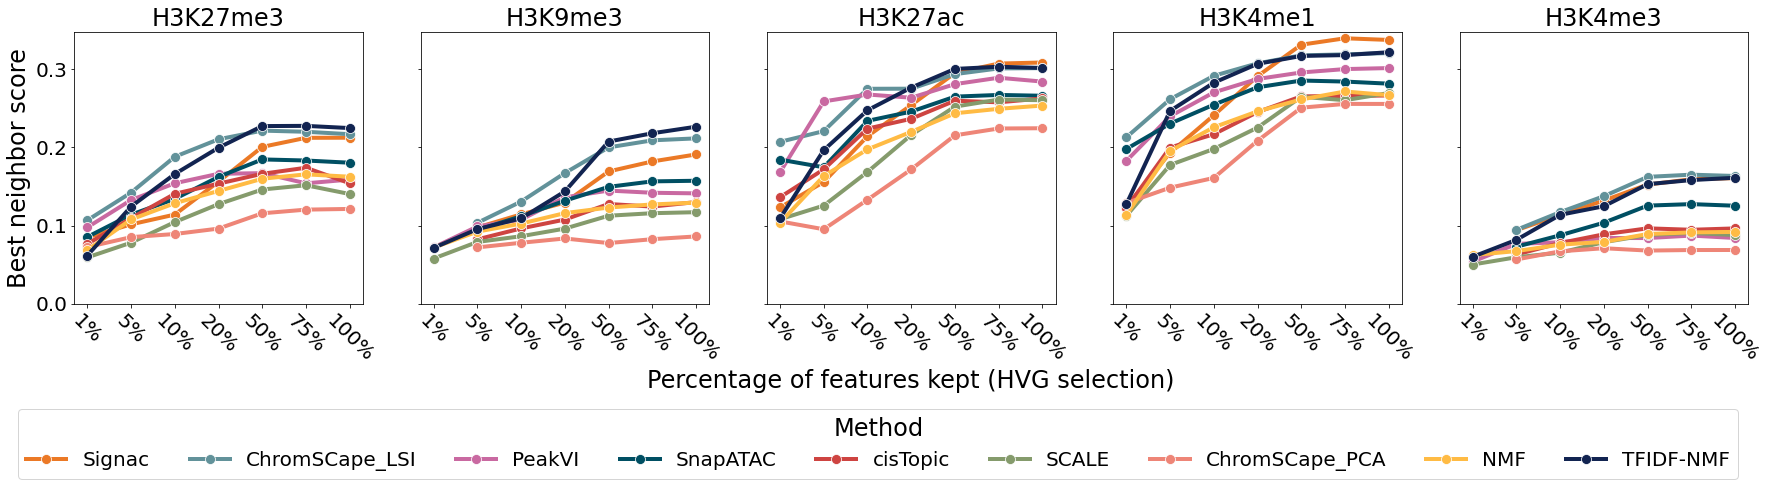

In [49]:
NICE_NAMES_HVG = {
        'raw': '100%',
        'filtered_hvg_75': '75%',
        'filtered_hvg_50': '50%',
        'filtered_hvg_20': '20%',
        'filtered_hvg_10': '10%',
        'filtered_hvg_5': '5%',
        'filtered_hvg_1': '1%',                       
}

local = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
local = local[local['feature_selection'].map(lambda x: x in NICE_NAMES_HVG)]
local['Condition'] = local['feature_selection'].map(lambda x: NICE_NAMES_HVG[x])
local['Condition'] = pd.Categorical(local['Condition'],
                                   categories=['1%', '5%', '10%', '20%', '50%', '75%', '100%',],
                                   ordered=True)
hvg_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()


lines = []
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)

y_min, y_max = hvg_effect['neighbor score'].min(), hvg_effect['neighbor score'].max()

for i, mark in enumerate(MARKS_ORDER):
  ax = axes[i]
  g= sns.lineplot(data=hvg_effect[hvg_effect['Mark'] == mark],
                  ax=ax,
                  x='Condition',
                  y='neighbor score',
                  hue='Method',
                  hue_order=METHODS_ORDER,
                  legend=False,
                  palette=palette,
                  linewidth=4,
                  marker='o',
                  markersize=10,
                  dashes=False,
                  )
  g.set(ylim=(0, y_max))
  #g.set(xscale='log', ylim=(0, ylim))
  ax.set_title(mark, size=24)
  #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
  ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
  g.set_xlabel('')
  if i == 2:
    g.set_xlabel('Percentage of features kept (HVG selection)', fontsize=24)
  if i == 0:
    ax.tick_params(axis='y', labelsize=20)
    g.set_ylabel('Best neighbor score', fontsize=24)



  lines.append(g)
#fig.suptitle(f'Effect of the coverage per cell', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=METHODS_ORDER,
    loc='upper right',
    bbox_to_anchor=(1, -.35),
    ncol=math.ceil(len(METHODS_ORDER)),
    markerscale=1,
    title='Method',
    fontsize=20,
    title_fontsize=24,
)

save_figure('hvg_effect.pdf', lgd)

plt.show()

<ipython-input-50-06cc1f20bd9b>:17: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  top_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()
<ipython-input-50-06cc1f20bd9b>:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


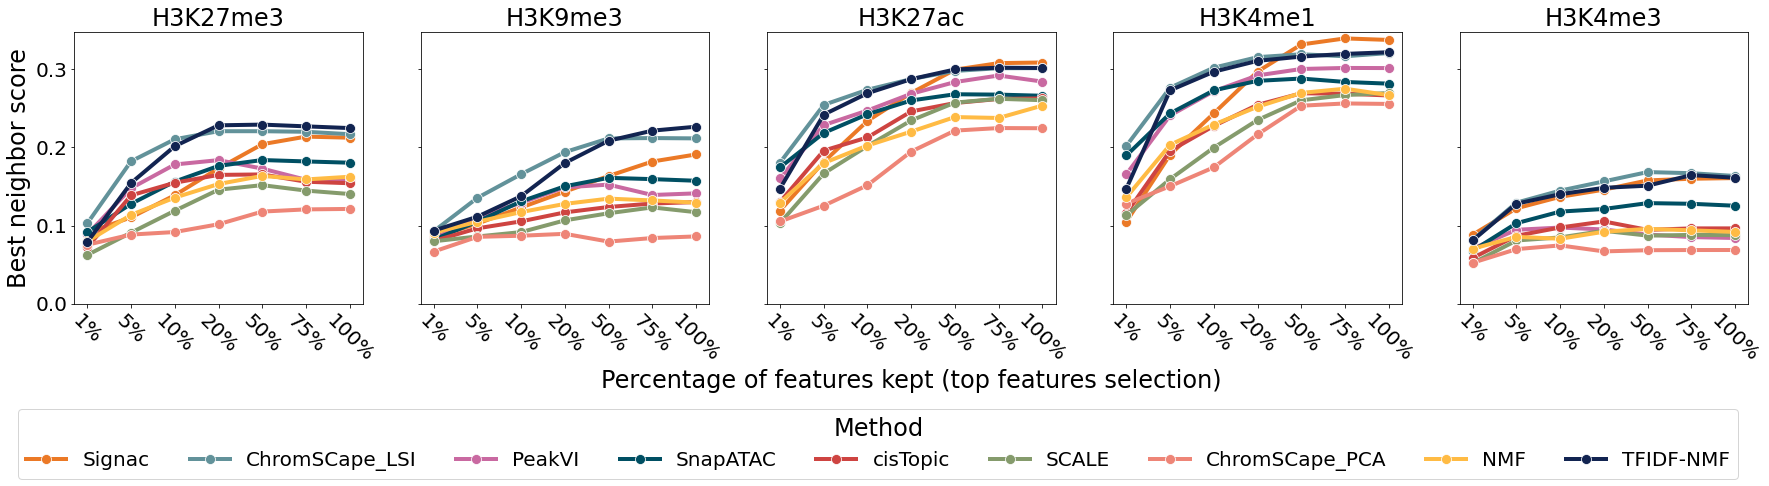

In [50]:
NICE_NAMES_TOP = {
        'raw': '100%',
        'filtered_q_75': '75%',
        'filtered_q_50': '50%',
        'filtered_q_20': '20%',
        'filtered_q_10': '10%',
        'filtered_q_5': '5%',
        'filtered_q_1': '1%',                       
}

local = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
local = local[local['feature_selection'].map(lambda x: x in NICE_NAMES_TOP)]
local['Condition'] = local['feature_selection'].map(lambda x: NICE_NAMES_TOP[x])
local['Condition'] = pd.Categorical(local['Condition'],
                                   categories=['1%', '5%', '10%', '20%', '50%', '75%', '100%',],
                                   ordered=True)
top_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()

lines = []
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)

y_min, y_max = top_effect['neighbor score'].min(), top_effect['neighbor score'].max()

for i, mark in enumerate(MARKS_ORDER):
  ax = axes[i]
  g= sns.lineplot(data=top_effect[top_effect['Mark'] == mark],
                  ax=ax,
                  x='Condition',
                  y='neighbor score',
                  hue='Method',
                  hue_order=METHODS_ORDER,
                  palette=palette,
                  legend=False,
                  linewidth=4,
                  marker='o',
                  markersize=10,
                  dashes=False,
                  )
  g.set(ylim=(0, y_max))
  #g.set(xscale='log', ylim=(0, ylim))
  ax.set_title(mark, size=24)
  #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
  ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
  g.set_xlabel('')
  if i == 2:
    g.set_xlabel('Percentage of features kept (top features selection)', fontsize=24)
  if i == 0:
    ax.tick_params(axis='y', labelsize=20)
    g.set_ylabel('Best neighbor score', fontsize=24)



  lines.append(g)
#fig.suptitle(f'Effect of the coverage per cell', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=METHODS_ORDER,
    loc='upper right',
    bbox_to_anchor=(1, -.35),
    ncol=math.ceil(len(METHODS_ORDER)),
    markerscale=1,
    title='Method',
    fontsize=20,
    title_fontsize=24,
)
save_figure('top_effect.pdf', lgd)

plt.show()

## Gradient figure

<ipython-input-51-9b376bcd848c>:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


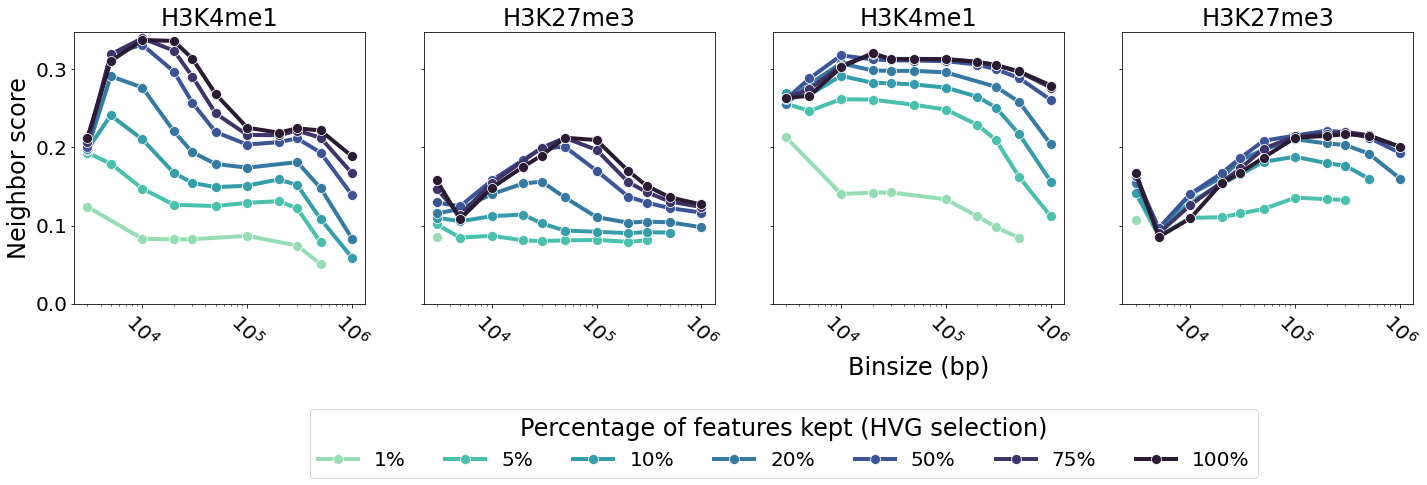

In [51]:
gradient_hvg = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
gradient_hvg = gradient_hvg[gradient_hvg['feature_selection'].map(lambda x: x in NICE_NAMES_HVG)]
gradient_hvg['Condition'] = gradient_hvg['feature_selection'].map(lambda x: NICE_NAMES_HVG[x])
gradient_hvg['Condition'] = pd.Categorical(gradient_hvg['Condition'],
                                           categories=['1%', '5%', '10%', '20%', '50%', '75%', '100%',],
                                           ordered=True)
y_min, y_max = gradient_hvg['neighbor score'].min(), gradient_hvg['neighbor score'].max()

lines = []
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)
for i, mark in enumerate(['H3K4me1', 'H3K27me3']):
  for j, method in enumerate(['Signac', 'ChromSCape_LSI']):
    ax=axes[i + j*2]
    g = sns.lineplot(data=gradient_hvg[(gradient_hvg['Mark'] == mark) & (gradient_hvg['Method'] == method)],
                    x='binsize_log',
                    y='neighbor score',
                    hue='Condition',
                    ax=ax,
                    legend=False,
                    palette=sns.color_palette("mako_r", len(gradient_hvg['Condition'].unique())),
                    linewidth=4,
                    marker='o',
                    markersize=10,
                    dashes=False,
                     )
    g.set(xscale='log', ylim=(0, y_max))
    
    #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
    g.set_xlabel('')
    ax.set_title(mark, size=24)
    if (i + j*2) == 2:
      g.set_xlabel('Binsize (bp)', fontsize=24)
    if i == 0:
      ax.tick_params(axis='y', labelsize=20)
      g.set_ylabel('Neighbor score', fontsize=24)
    lines.append(g)

#fig.suptitle(f'Effect of the coverage per cell', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=['1%', '5%', '10%', '20%', '50%', '75%', '100%',],
    loc='upper right',
    bbox_to_anchor=(0.5, -0.35),
    ncol=len(gradient_hvg['Condition'].unique()),
    markerscale=1,
    title='Percentage of features kept (HVG selection)',
    fontsize=20,
    title_fontsize=24,
)
save_figure('hvg_gradients.pdf', lgd)
plt.show()

In [52]:
gradient_hvg[(gradient_hvg['Mark'] == mark) & (gradient_hvg['Method'] == method)].max()

<ipython-input-52-3d0a7025a0cd>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gradient_hvg[(gradient_hvg['Mark'] == mark) & (gradient_hvg['Method'] == method)].max()


neighbor score                  0.22159
AULC                            0.12651
Avg                            0.138567
source               PairedTag_Zhu_2021
Mark                           H3K27me3
Method                   ChromSCape_LSI
feature_selection                   raw
binsize                         1000kbp
binsize_log                   1000000.0
Condition                          100%
dtype: object

# QC

## Dataset construction

In [53]:
NICE_NAMES_QC = {
        'raw': '100%',
        'filtered_cell_q_10_100': '90%',
        'filtered_cell_q_20_100': '80%',
        'filtered_cell_q_30_100': '70%',
        'filtered_cell_q_40_100': '60%',
        'filtered_cell_q_50_100': '50%',
        'filtered_cell_q_60_100': '40%',
}

local = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
local = local[local['feature_selection'].map(lambda x: x in NICE_NAMES_QC)]
local['Condition'] = local['feature_selection'].map(lambda x: NICE_NAMES_QC[x])
local['Condition'] = pd.Categorical(local['Condition'],
                                   categories=['40%', '50%', '60%', '70%', '80%', '90%', '100%',],
                                   ordered=True)
qc_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()

<ipython-input-53-4fe54b8c5fd3>:17: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  qc_effect = local.groupby(['Mark', 'Method', 'Condition'], as_index=False).max()


## Plots

<ipython-input-54-67acb0240753>:37: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


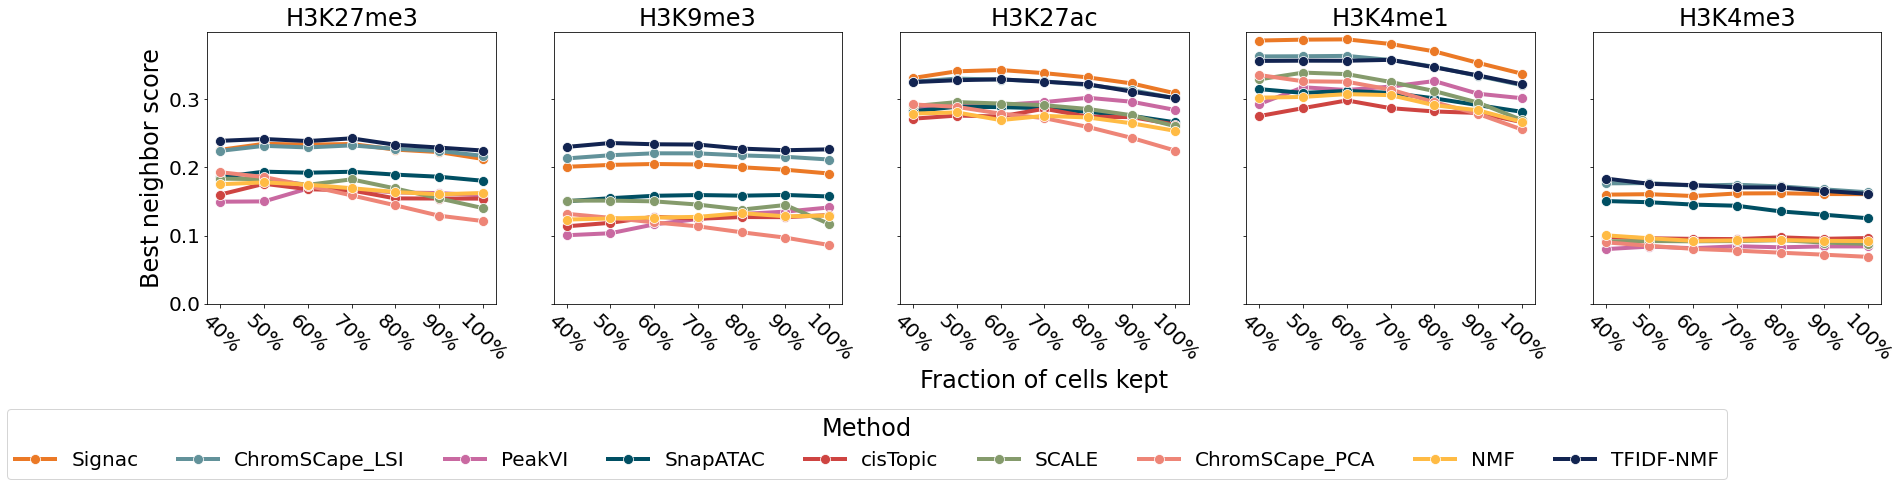

In [54]:
lines = []
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)

y_min, y_max = qc_effect['neighbor score'].min(), qc_effect['neighbor score'].max()

for i, mark in enumerate(MARKS_ORDER):
  ax = axes[i]
  g= sns.lineplot(data=qc_effect[qc_effect['Mark'] == mark],
                  ax=ax,
                  x='Condition',
                  y='neighbor score',
                  hue='Method',
                  hue_order=METHODS_ORDER,
                  legend=False,
                  palette=palette,
                  linewidth=4,
                  marker='o',
                  markersize=10,
                  dashes=False,
                  )
  g.set(ylim=(0, y_max))
  #g.set(xscale='log', ylim=(0, ylim))
  ax.set_title(mark, size=24)
  #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
  ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
  g.set_xlabel('')
  if i == 2:
    g.set_xlabel('Fraction of cells kept', fontsize=24)
  if i == 0:
    ax.tick_params(axis='y', labelsize=20)
    g.set_ylabel('Best neighbor score', fontsize=24)



  lines.append(g)
#fig.suptitle(f'Effect of the coverage per cell', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=METHODS_ORDER,
    loc='upper right',
    bbox_to_anchor=(0.5, -.35),
    ncol=math.ceil(len(METHODS_ORDER)),
    markerscale=1,
    title='Method',
    fontsize=20,
    title_fontsize=24,
)

save_figure('qc_effect.pdf', lgd)
plt.show()

## Table

In [55]:
acc = []

for method in METHODS_ORDER:
  for mark in MARKS_ORDER:
    tmp = qc_effect[(qc_effect['Mark'] == mark) & (qc_effect['Method'] == method)]
    high = tmp['neighbor score'].max()
    low = list(tmp[tmp['Condition'] == '100%'].to_dict()['neighbor score'].values())[0]
    acc.append({'Method': method, 'Mark': mark, 'best increase': (high - low) / low})

gains = pd.DataFrame(acc)
print(gains[(gains['Method'] == 'Signac') | (gains['Method'] == 'ChromSCape_LSI')].to_latex())
#print(gains.groupby('Method',).mean().to_latex())

\begin{tabular}{lllr}
\toprule
{} &          Method &      Mark &  best increase \\
\midrule
0 &          Signac &  H3K27me3 &       0.104490 \\
1 &          Signac &   H3K9me3 &       0.073302 \\
2 &          Signac &   H3K27ac &       0.110932 \\
3 &          Signac &   H3K4me1 &       0.149131 \\
4 &          Signac &   H3K4me3 &       0.008321 \\
5 &  ChromSCape\_LSI &  H3K27me3 &       0.071008 \\
6 &  ChromSCape\_LSI &   H3K9me3 &       0.043185 \\
7 &  ChromSCape\_LSI &   H3K27ac &       0.095707 \\
8 &  ChromSCape\_LSI &   H3K4me1 &       0.133756 \\
9 &  ChromSCape\_LSI &   H3K4me3 &       0.082773 \\
\bottomrule
\end{tabular}



In [56]:
acc = []

for method in METHODS_ORDER:
  for mark in MARKS_ORDER:
    tmp = qc_effect[(qc_effect['Mark'] == mark) & (qc_effect['Method'] == method)]
    high = tmp['neighbor score'].max()
    low = list(tmp[tmp['Condition'] == '100%'].to_dict()['neighbor score'].values())[0]
    acc.append({'Method': method, 'Mark': mark, 'best increase': (high - low) / low})

gains = pd.DataFrame(acc)
print(gains.groupby('Mark',).mean().to_latex())
print(gains.groupby('Method',).mean().to_latex())

\begin{tabular}{lr}
\toprule
{} &  best increase \\
Mark     &                \\
\midrule
H3K27ac  &       0.120208 \\
H3K27me3 &       0.169909 \\
H3K4me1  &       0.159872 \\
H3K4me3  &       0.101575 \\
H3K9me3  &       0.113766 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  best increase \\
Method         &                \\
\midrule
ChromSCape\_LSI &       0.085286 \\
ChromSCape\_PCA &       0.409814 \\
NMF            &       0.095071 \\
PeakVI         &       0.042623 \\
SCALE          &       0.211121 \\
Signac         &       0.089235 \\
SnapATAC       &       0.098905 \\
TFIDF-NMF      &       0.092807 \\
cisTopic       &       0.072732 \\
\bottomrule
\end{tabular}



## Gradient figure

<ipython-input-57-91598cf8148a>:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = plt.legend(


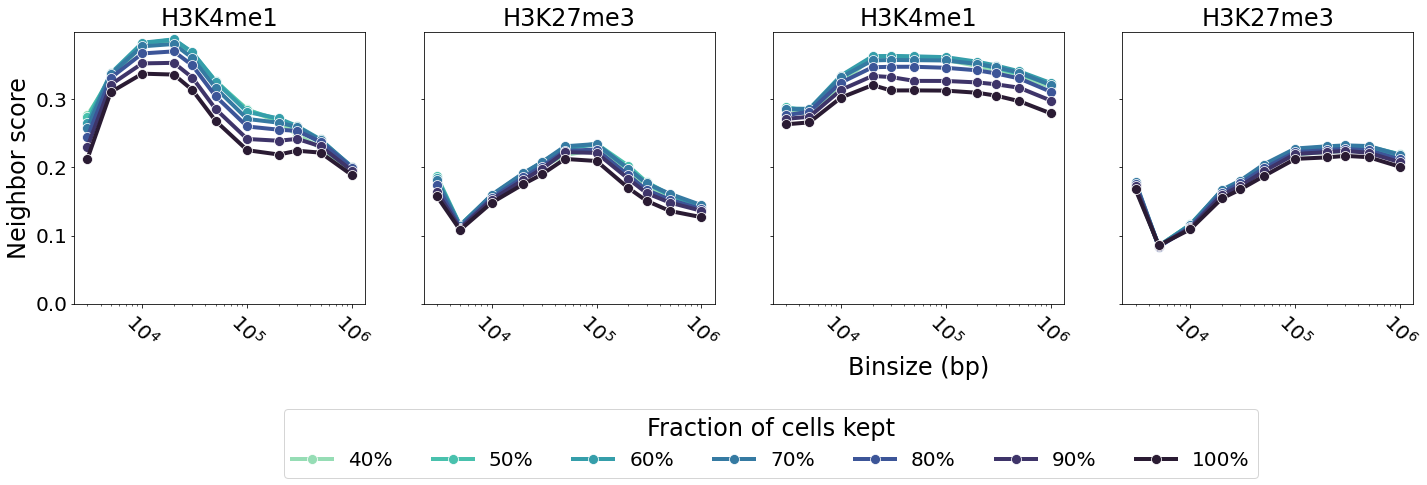

In [57]:
gardient_qc = scores[scores['source'] == 'PairedTag_Zhu_2021'] # only PairedTag
gardient_qc = gardient_qc[gardient_qc['feature_selection'].map(lambda x: x in NICE_NAMES_QC)]
gardient_qc['Condition'] = gardient_qc['feature_selection'].map(lambda x: NICE_NAMES_QC[x])
gardient_qc['Condition'] = pd.Categorical(gardient_qc['Condition'],
                                   categories=['40%', '50%', '60%', '70%', '80%', '90%', '100%',],
                                   ordered=True)

y_min, y_max = gardient_qc['neighbor score'].min(), gardient_qc['neighbor score'].max()

lines = []
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)
for i, mark in enumerate(['H3K4me1', 'H3K27me3']):
  for j, method in enumerate(['Signac', 'ChromSCape_LSI']):
    ax=axes[i + j*2]
    g = sns.lineplot(data=gardient_qc[(gardient_qc['Mark'] == mark) & (gardient_qc['Method']==method)],
                x='binsize_log',
                y='neighbor score',
                hue='Condition',
                ax=ax,
                legend=False,
                palette=sns.color_palette("mako_r", len(gardient_qc['Condition'].unique())),
                linewidth=4,
                marker='o',
                markersize=10,
                dashes=False,
                )
    g.set(xscale='log', ylim=(0, y_max))
    #ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
    g.set_xlabel('')
    if (i + j*2) == 2:
      g.set_xlabel('Binsize (bp)', fontsize=24)
    ax.set_title(mark, size=24)
    if i == 0:
      ax.tick_params(axis='y', labelsize=20)
      g.set_ylabel('Neighbor score', fontsize=24)
    lines.append(g)

#fig.suptitle(f'Effect of the coverage per cell', va='top', size=22)
lgd = plt.legend(
    lines,
    labels=['40%', '50%', '60%', '70%', '80%', '90%', '100%',],
    loc='upper right',
    bbox_to_anchor=(0.5, -0.35),
    ncol=len(gardient_qc['Condition'].unique()),
    markerscale=1,
    title='Fraction of cells kept',
    fontsize=20,
    title_fontsize=24,
)

save_figure('qc_gradient.pdf', lgd)
plt.show()

# Runtime

In [58]:
def generate_time_df(path, parser):
  res = []
  with open(path, 'r') as f:
    for line in f.readlines():
      if 'Time to run' in line:
        res.append(parser(line))
  return pd.DataFrame.from_records(res)


def plot_timing(df, key, key_name, fname):
  lines = []
  fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharey=True)

  y_max = df['Time (s)'].max()

  g = sns.lineplot(data=df,
                   ax=ax,
                   x=key,
                   y='Time (s)',
                   hue='Method',
                   hue_order=METHODS_ORDER,
                   #legend=False,
                   palette=palette,
                   linewidth=4,
                   marker='o',
                   markersize=10,
                   dashes=False,
                   )
  g.set(ylim=(0, 1.1*y_max))

  ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
  g.set_xlabel('')
  g.set_xlabel(key_name, fontsize=24)
  ax.tick_params(axis='y', labelsize=20)
  g.set_ylabel('Time (s)', fontsize=24)

  lines.append(g)

  lgd = plt.legend(loc='upper left',
                  bbox_to_anchor=(1.1, 1),
                  ncol=1,
                  markerscale=1,
                  title='Method',
                  fontsize=20,
                  title_fontsize=24,
  )

  save_figure(fname, lgd)

  plt.show()

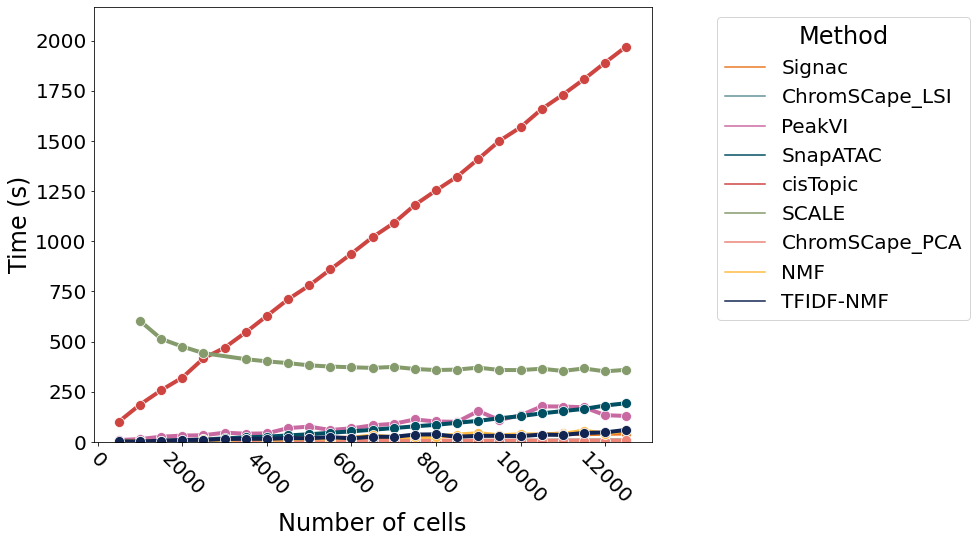

In [62]:
def parse_time_line_samples(line):
  line = line.rstrip('"\n')
  split = line.split(' ')
  return {
    'Time (s)': float(split[-1]),
    'Method': split[-3],
    'Cells': int(split[-2].split('/')[-2].split('_')[-1]),
  }

timing_samples = generate_time_df('time_correct.txt', parse_time_line_samples)
plot_timing(timing_samples, 'Cells', 'Number of cells', 'Fig2R3_runtime_samples.pdf')

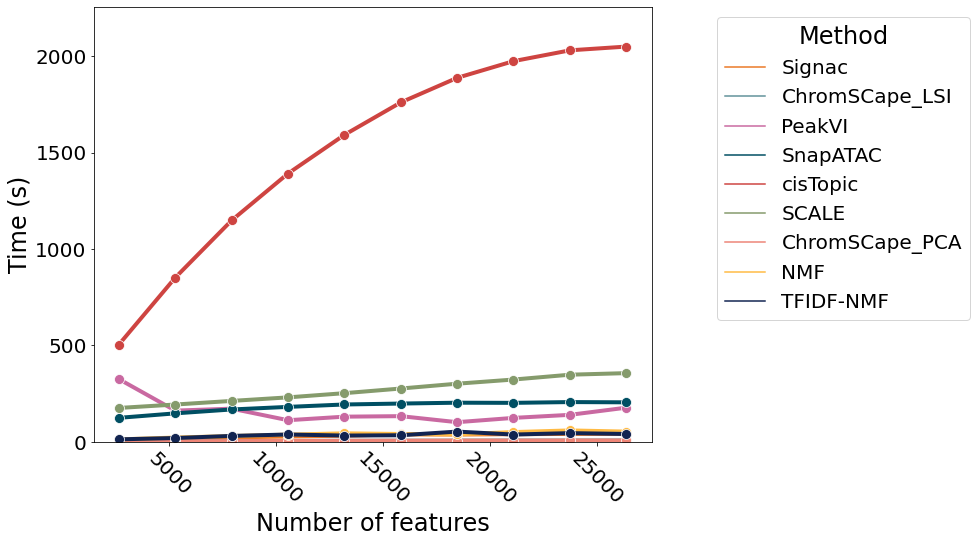

In [63]:
def parse_time_line_features(line):
  line = line.rstrip('"\n')
  split = line.split(' ')
  return {
    'Time (s)': float(split[-1]),
    'Method': split[-3],
    'Features': int(split[-2].split('/')[-2].split('_')[-1]) * 26360 / 100,
  }

timing_features = generate_time_df('time_features.txt', parse_time_line_features)
plot_timing(timing_features, 'Features', 'Number of features', 'Fig2R4_runtime_features.pdf')

# Whitening

In [ ]:
WHITENING_METHODS = [
        'Signac d=50',
        'Signac d=10',
        'ChromSCape_LSI whitened d=10',
        'ChromSCape_LSI d=50',
        'ChromSCape_LSI d=10',  
]

NICE_NAMES_WHITE = {
        'Signac': 'Signac d=50',
        'Signac_10': 'Signac d=10',
        'ChromSCape_white_LSI': 'ChromSCape_LSI whitened d=10',
        'ChromSCape_LSI_50': 'ChromSCape_LSI d=50',
        'ChromSCape_LSI': 'ChromSCape_LSI d=10',
}

In [ ]:
local = scores[(scores['feature_selection'] == 'raw') & (scores['source'] == 'PairedTag_Zhu_2021')]
local = local[local['Method'].map(lambda x: x in NICE_NAMES_WHITE)]
local['Method'] = pd.Categorical(local['Method'],
                                  categories=NICE_NAMES_WHITE.keys(),
                                  ordered=True)
local['Condition'] = local['Method'].map(lambda x: NICE_NAMES_WHITE[x])

lines = []
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)

for i, mark in enumerate(MARKS_ORDER):
  ax=axes[i]
  g = sns.lineplot(
      data=local[(local['Mark'] == mark)],
      x='binsize_log',
      y='neighbor score',
      hue='Condition',
      hue_order=WHITENING_METHODS,
      ax=ax,
      legend=False,
      linewidth=4,
      palette='Set2',
      marker='o',
      markersize=10,
      dashes=False,
  )
  g.set(xscale='log', ylim=(0, y_max))
  ax.tick_params(axis='x', labelrotation = -45, labelsize=20)
  g.set_xlabel('')
  ax.set_title(mark, size=24)
  if i == 2:
    g.set_xlabel('Binsize (bp)', fontsize=24)
  if i == 0:
    ax.tick_params(axis='y', labelsize=20)
    g.set_ylabel('Neighbor score', fontsize=24)
  lines.append(g)

lgd = plt.legend(
    lines,
    labels=WHITENING_METHODS,
    loc='upper right',
    bbox_to_anchor=(.7, -.30),
    ncol=math.ceil(len(WHITENING_METHODS)),
    markerscale=1,
    title='Method',
    fontsize=20,
    title_fontsize=24,
)
save_figure('whitening_effect.pdf', lgd)
plt.show()

# Supervised metrics

# Shell Launchers

In [ ]:
NUMBER_OF_CELLS = {
    'H3K4me1': 12962,
    'H3K4me3': 7465,
    'H3K9me3': 12044,
    'H3K27me3': 6534,
    'H3K27ac': 11749
}

In [ ]:
for mark in MARKS_ORDER:
  for thres in [1, 5, 10, 20, 50, 75]:
    for sel in ['q', 'hvg']:
      fe = f'filtered_{sel}_{thres}'
      print(f'time python3 compute_scores.py '
            f'--output_path=/home/gamazeps/data/scores/PairedTag_Zhu_2021/{mark}/{fe} '
            f'--embeddings_path=/home/gamazeps/data/embeddings/PairedTag_Zhu_2021/{mark}/{fe} '
            f'--mode=RNA  '
            f'--all '
            f'--gt_path=/home/gamazeps/data/input/PairedTag_Zhu_2021/RNA/01.Paired-Tag_seq_RNA_filtered_matrix')
      """
      for eng in [1000, 500, 300, 200, 100, 50, 30, 20, 10]:
        eng = f'{eng}k' 
        matrix_path = f'/home/gamazeps/data/matrices/PairedTag_Zhu_2021/{mark}/{fe}/{eng}'
        emb_path = f'/home/gamazeps/data/embeddings/PairedTag_Zhu_2021/{mark}/{fe}/{eng}'
        #print(f'mkdir -p {output_path}')
        #print(f'Rscript filter_sce.R --input_path={input_path} --output_path={output_path} --percent_features={thres/100}')
        print(f'time python3 nmf_process.py  '
              f'--input_path={matrix_path}  '
              f'--output_path={emb_path} ')
      """

## All Grosselin

In [ ]:
ORIG_BS ={
    'H3K4me3': 5,
    'H3K27me3': 50,
}

for mark in ['H3K4me3', 'H3K27me3']:
  binsizes = [1000, 500, 300, 200, 100, 50, 30, 20, 10, 5] if mark == 'H3K4me3' else [1000, 500, 300, 200, 100, 50]
  binsizes = [ 5] if mark == 'H3K4me3' else [50]

  for bs in binsizes:
    matrix_path = f'/home/gamazeps/data/matrices/scChIP_Grosselin_2019/{mark}/raw/{bs}k'
    emb_path = f'/home/gamazeps/data/embeddings/scChIP_Grosselin_2019/{mark}/raw/{bs}k'
    scores_path = f'/home/gamazeps/data/scores/scChIP_Grosselin_2019/{mark}/raw/{bs}k'
    gt_path = f'/home/gamazeps/data/matrices/scChIP_Grosselin_2019/{mark}/raw/{ORIG_BS[mark]}k'
    
    #if bs != ORIG_BS[mark]:
    print(f'time python resize_bins.py '
          f'--input_path={gt_path} '
          f'--output_dir={matrix_path} '
          f'--binsize={bs}')
    
    print(f'mkdir -p {emb_path}')

    print(f'time Rscript R_analysis.R  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} ')
    print(f'time python3 nmf_process.py  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} ')
    print(f'time python3 peakVI_process.py  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} ')
    print(f'time python3 scale_process.py  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} ')
    
    print(f'mkdir -p {scores_path}')

    print(f'time python3 compute_supervised_metrics.py '
          f'--output_path={scores_path} '
          f'--embeddings_path={emb_path} '
          f'--mode=RNA '
          f'--gt_path={gt_path}')

## scCutTAGPro

In [ ]:
# Compute embeddings

for mark in MARKS_ORDER:
  engs = ['GeneTSS',]
  engs += [f'SicerPseudoBulk{w}' for w in [200, 500, 2000, 5000, 20000]]
  engs += [f'{bs}k' for bs in [1000, 500, 300, 200, 100, 50, 30, 20, 10]]
  for eng in engs:
    print(f'mkdir -p {os.path.join("/home/gamazeps/data/embeddings/scCutTagPro_Zhang_2021", mark, "raw", eng)}')

    print(f'time Rscript R_analysis.R  '
          f'--input_path={os.path.join("/home/gamazeps/data/matrices/scCutTagPro_Zhang_2021", mark, "raw", eng)}  '
          f'--output_path={os.path.join("/home/gamazeps/data/embeddings/scCutTagPro_Zhang_2021", mark, "raw", eng)} ')
    print(f'time python3 nmf_process.py  '
          f'--input_path={os.path.join("/home/gamazeps/data/matrices/scCutTagPro_Zhang_2021", mark, "raw", eng)}  '
          f'--output_path={os.path.join("/home/gamazeps/data/embeddings/scCutTagPro_Zhang_2021", mark, "raw", eng)} ')
    print(f'time python3 peakVI_process.py  '
          f'--input_path={os.path.join("/home/gamazeps/data/matrices/scCutTagPro_Zhang_2021", mark, "raw", eng)}  '
          f'--output_path={os.path.join("/home/gamazeps/data/embeddings/scCutTagPro_Zhang_2021", mark, "raw", eng)} ')
    print(f'time python3 scale_process.py  '
          f'--input_path={os.path.join("/home/gamazeps/data/matrices/scCutTagPro_Zhang_2021", mark, "raw", eng)}  '
          f'--output_path={os.path.join("/home/gamazeps/data/embeddings/scCutTagPro_Zhang_2021", mark, "raw", eng)} ')

In [ ]:
# Computing the scores

for mark in MARKS_ORDER:
  print(f'time python3 compute_scores.py '
        f'--output_path=/home/gamazeps/data/scores/scCutTagPro_Zhang_2021/{mark}/raw '
        f'--embeddings_path=/home/gamazeps/data/embeddings/scCutTagPro_Zhang_2021/{mark}/raw '
        f'--mode=ADT  '
        f'--all '
        f'--gt_path=/home/gamazeps/data/input/scCutTagPro_Zhang_2021/{mark}/adt.csv')
  engs = ['GeneTSS', 'PseudoBulk', 'SicerPseudoBulk200',  'SicerPseudoBulk2000',  'SicerPseudoBulk20000',  'SicerPseudoBulk500',  'SicerPseudoBulk5000',]
  engs += [f'{bs}k' for bs in [1000, 500, 300, 200, 100, 50, 30, 20, 10]]
  for eng in engs:
    print(f'time python3 compute_supervised_metrics.py '
          f'--output_path=/home/gamazeps/data/scores/scCutTagPro_Zhang_2021/{mark}/raw/{eng} '
          f'--embeddings_path=/home/gamazeps/data/embeddings/scCutTagPro_Zhang_2021/{mark}/raw/{eng} '
          f'--gt_path=/home/gamazeps/data/input/scCutTagPro_Zhang_2021/{mark}')

## PairedTag

In [ ]:
# Compute the scores

for mark in MARKS_ORDER:
  for fe in ORDER:
    """
    print(f'time python3 compute_scores.py '
          f'--output_path=/home/gamazeps/data/scores/PairedTag_Zhu_2021/{mark}/{fe} '
          f'--embeddings_path=/home/gamazeps/data/embeddings/PairedTag_Zhu_2021/{mark}/{fe} '
          f'--mode=RNA  '
          f'--all '
          f'--gt_path=/home/gamazeps/data/input/PairedTag_Zhu_2021/RNA/01.Paired-Tag_seq_RNA_filtered_matrix')
    """
    engs = ['GeneTSS']
    engs += [f'{bs}k' for bs in [1000, 500, 300, 200, 100, 50, 30, 20, 10]]
    for eng in engs:
      print(f'time python3 compute_supervised_metrics.py '
            f'--output_path=/home/gamazeps/data/scores/PairedTag_Zhu_2021/{mark}/{fe}/{eng} '
            f'--embeddings_path=/home/gamazeps/data/embeddings/PairedTag_Zhu_2021/{mark}/{fe}/{eng} '
            f'--gt_path=/home/gamazeps/data/input/PairedTag_Zhu_2021/RNA/01.Paired-Tag_seq_RNA_filtered_matrix')

## Timing

Time per number of samples

In [ ]:
for mark in ['H3K4me1']:
  #for eng in []:
  #  eng = f'{eng}k'
  #for eng in [1000, 500, 300, 200, 100, 50, 30, 20, 10]:
  for eng in [100]:
    eng = f'{eng}k'
    for fs in range(500, NUMBER_OF_CELLS[mark], 500):
      s = f'sampled_cell_n_{fs}'
      #print(f'mkdir -p {os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, s, eng)}')
      #print(f'mkdir -p {os.path.join("/home/gamazeps/data/embeddings/PairedTag_Zhu_2021", mark, s, eng)}')

    #print(f'Rscript sample_cells.R --input_path={os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, "raw", eng)}')
    for fs in range(500, NUMBER_OF_CELLS[mark], 500):
      s = f'sampled_cell_n_{fs}'
      matrix_path = os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, s, eng)
      emb_path = os.path.join("/home/gamazeps/data/embeddings/PairedTag_Zhu_2021", mark, s, eng)
      log_file = 'logs/time_correct.txt'

      print(f'time Rscript R_analysis.R  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')
      print(f'time python3 nmf_process.py  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')

      print(f'time python3 peakVI_process.py  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')
      print(f'time python3 scale_process.py  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')

In [ ]:
for mark in ['H3K4me1']:
  for eng in [100]:
    eng = f'{eng}k'
    for fs in range(10, 101, 10):
      s = f'filtered_q_{fs}'
      raw_path = os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, 'raw', eng)
      matrix_path = os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, s, eng)
      emb_path = os.path.join("/home/gamazeps/data/embeddings/PairedTag_Zhu_2021", mark, s, eng)
      log_file = 'logs/time_features.txt'

      '''
      print(f'mkdir -p {matrix_path}')
      print(f'mkdir -p {emb_path}')
      print(f'Rscript filter_sce.R '
            f'--input_path={raw_path} '
            f'--output_path={matrix_path} '
            f'--percent_features={fs/100}')
      '''
      
      print(f'time Rscript R_analysis.R  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')
      print(f'time python3 nmf_process.py  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')

      print(f'time python3 peakVI_process.py  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')
      print(f'time python3 scale_process.py  '
            f'--input_path={matrix_path}  '
            f'--output_path={emb_path} '
            f'>> {log_file}')


In [ ]:
for mark in ['H3K4me1']:
  engs = ['GeneTSS']
  engs += [f'{bs}k' for bs in [1000, 500, 300, 200, 100, 50, 30, 20, 10]]
  for eng in engs:
    matrix_path = os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, 'raw', eng)
    emb_path = os.path.join("/home/gamazeps/data/embeddings/PairedTag_Zhu_2021", mark, 'raw', eng)
    log_file = 'logs/time_eng.txt'
    
    print(f'time Rscript R_analysis.R  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} '
          f'>> {log_file}')
    print(f'time python3 nmf_process.py  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} '
          f'>> {log_file}')
    print(f'time python3 peakVI_process.py  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} '
          f'>> {log_file}')
    print(f'time python3 scale_process.py  '
          f'--input_path={matrix_path}  '
          f'--output_path={emb_path} '
          f'>> {log_file}')

In [ ]:
for mark in MARKS_ORDER:
  #for eng in []:
  #  eng = f'{eng}k'
  for eng in [1000, 500, 300, 200, 100, 50, 30, 20, 10]:
    eng = f'{eng}k'
    for fs in [20, 40, 60, 80]:
      s = f'sampled_cell_p_{fs}'
      print(f'mkdir -p {os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, s, eng)}')
      print(f'mkdir -p {os.path.join("/home/gamazeps/data/embeddings/PairedTag_Zhu_2021", mark, s, eng)}')

    print(f'Rscript sample_cells.R --input_path={os.path.join("/home/gamazeps/data/matrices/PairedTag_Zhu_2021", mark, "raw", eng)}')

In [ ]:
for mark in MARKS_ORDER:
  bp = os.path.join('/home/gamazeps/data/matrices/PairedTag_Zhu_2021', mark)
  for eng in [10]:
    eng = f'{eng}k'
    for i in [0, 10, 20, 30, 40 , 50, 60]:       
      path = os.path.join(bp, f'filtered_cell_q_{i}_{100}', eng)
      print(f'mkdir -p {path}')
    for i in [0, 10, 20, 30, 40 , 50]:       
      path = os.path.join(bp, f'filtered_cell_q_{i}_{i+50}', eng)
      print(f'mkdir -p {path}')
    print(f'mkdir -p {os.path.join(bp, "filtered_cell_baseline", eng)}')
    input_path = os.path.join(bp, 'raw', eng)
    print(f'Rscript filter_cells_quality.R --input_path={input_path}')

In [ ]:
for mark in MARKS_ORDER:
  for eng in [1000, 500, 300, 200, 100, 50, 30, 20]:
    eng = f'{eng}k'
  # for eng in ['GeneTSS', 'PseudoBulk']:
    print(f'time python3  compute_supervised_metrics.py  '
          f'--output_path={os.path.join("/home/gamazeps/data/scores/PairedTag_Zhu_2021", mark, "raw", eng)}  '
          f'--embeddings_path={os.path.join("/home/gamazeps/data/embeddings/PairedTag_Zhu_2021", mark, "raw", eng)} '
          f'--mode=RNA '
          f'--gt_path=/home/gamazeps/data/input/PairedTag_Zhu_2021/RNA/01.Paired-Tag_seq_RNA_filtered_matrix')